The following code defines LSTM model setup trained on audio modality data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

2022-05-28 10:18:05.222719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
import sys
sys.path.insert(1, '../')

from data_preparation import prepare_x_data, get_Y_labels, reshape_Y, reshape_X, unscale_Y

In [4]:
scaler = StandardScaler()

## Data preparation

Data preparation includes: <br>
<ul>
  <li>selecting necessary features from source files</li>
  <li>creating combined dataset for the model training</li>
  <li>reshaping data for model training.</li>


### X data - audio features

In [5]:
x_train = prepare_x_data('../Data/LLDs_audio_eGeMAPS/train',';', 2, scaler) 

In [6]:
x_test = prepare_x_data('../Data/LLDs_audio_eGeMAPS/dev',';', 2, scaler) 

### Y data - YMRS score

In [7]:
y_train = get_Y_labels('../Data/labels_metadata.csv', 60, 164, scaler)
y_train = reshape_Y(y_train,len(x_train),1,1)

In [8]:
y_test = get_Y_labels('../Data/labels_metadata.csv', 0, 60, scaler)
y_test = reshape_Y(y_test,len(x_test),1,1)

## Model setup - LSTM

Proposed model for LSTM recurrent neural network architecture.

### Defining the model

In [9]:
model = keras.Sequential()

2022-05-28 10:18:18.386429: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-28 10:18:18.396909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-28 10:18:19.992873: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:927] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-28 10:18:19.997361: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 268.26GiB/s
2022-05-28 10:18:19.997446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 10:18:20.026903: I tensorflow/stream_executor/plat

In [10]:
model.add(layers.LSTM(units = 12, input_shape=(None,23), return_sequences=True))
model.add(layers.Dropout(0.004))
model.add(layers.LSTM(units = 11, input_shape=(None,15), return_sequences=False))
model.add(layers.Dropout(0.004))
model.add(layers.Dense(1, activation='linear'))

In [11]:
model.compile(
    loss="mse", 
    metrics=[keras.metrics.MeanAbsoluteError()],
    optimizer=keras.optimizers.Adam(learning_rate=0.004)
    )

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 12)          1728      
_________________________________________________________________
dropout (Dropout)            (None, None, 12)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12        
Total params: 2,796
Trainable params: 2,796
Non-trainable params: 0
_________________________________________________________________


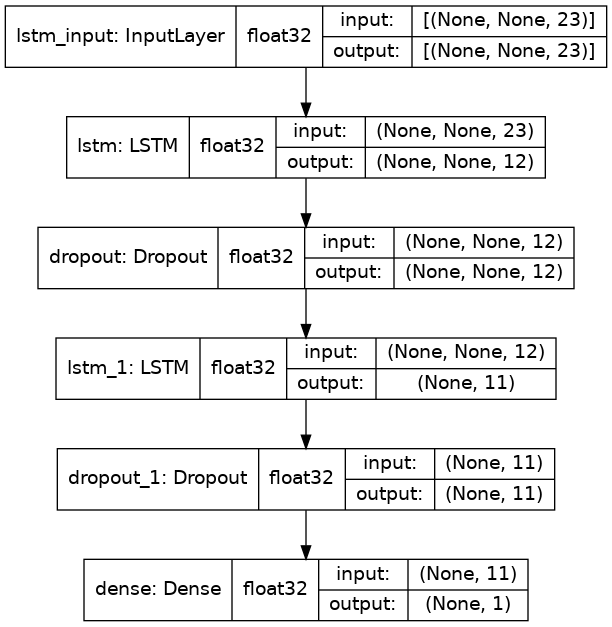

In [13]:
keras.utils.plot_model(model=model, show_dtype=True, show_layer_names=True, show_shapes=True, to_file='LSTM_unimodal_audio.png')

### Model training

Model training setup is based on an iterative approach where model is trained one file at a time, then learned parameters are saved and loaded in the next iterative step. This setup is necessary due to the fact that source files does not have an uniform size and differ in number of frames.

In [14]:
train_index = 0


train_eval = []
train_loss = []
train_mae = []

for file in x_train:         
        file = np.array(file).reshape((1, file.shape[0], -1))

        model.fit(x=file, 
                y=y_train[train_index], 
                epochs=10,
                batch_size = len(file)) 
        
        scores = model.evaluate(file, y_train[train_index], verbose = 0)
        train_eval.append(scores)
        train_loss.append(scores[0]) 
        train_mae.append(scores[1])
                                        
                                        
        model.save(r'LSTM_train_audio', include_optimizer=True) # Save model configuration to Saved_models.
        model = keras.models.load_model(r'LSTM_train_audio') # Load model configuration from Saved_models.
        train_index += 1

2022-05-28 10:18:22.284731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-28 10:18:22.288596: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994365000 Hz


Epoch 1/10


2022-05-28 10:18:23.682909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-28 10:18:24.042391: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1/1 [==============================] - 4s 4s/step - loss: 0.0109 - mean_absolute_error: 0.1046
Epoch 2/10
1/1 [==============================] - 1s 568ms/step - loss: 0.0036 - mean_absolute_error: 0.0601
Epoch 3/10
1/1 [==============================] - 1s 840ms/step - loss: 0.0062 - mean_absolute_error: 0.0787
Epoch 4/10
1/1 [==============================] - 1s 564ms/step - loss: 0.0019 - mean_absolute_error: 0.0437
Epoch 5/10
1/1 [==============================] - 1s 570ms/step - loss: 5.0337e-04 - mean_absolute_error: 0.0224
Epoch 6/10
1/1 [==============================] - 1s 568ms/step - loss: 9.7630e-05 - mean_absolute_error: 0.0099
Epoch 7/10
1/1 [==============================] - 1s 580ms/step - loss: 0.0011 - mean_absolute_error: 0.0333
Epoch 8/10
1/1 [==============================] - 1s 574ms/step - loss: 0.0017 - mean_absolute_error: 0.0410
Epoch 9/10
1/1 [==============================] - 1s 737ms/step - loss: 8.5046e-04 - mean_absolute_error: 0.0292
Epoch 10/10
1/1 [====

2022-05-28 10:18:34.793977: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.3734 - mean_absolute_error: 0.6111
Epoch 2/10
1/1 [==============================] - 1s 762ms/step - loss: 0.2265 - mean_absolute_error: 0.4759
Epoch 3/10
1/1 [==============================] - 1s 879ms/step - loss: 0.1246 - mean_absolute_error: 0.3530
Epoch 4/10
1/1 [==============================] - 1s 726ms/step - loss: 0.0564 - mean_absolute_error: 0.2375
Epoch 5/10
1/1 [==============================] - 1s 696ms/step - loss: 0.0191 - mean_absolute_error: 0.1383
Epoch 6/10
1/1 [==============================] - 1s 734ms/step - loss: 6.3934e-04 - mean_absolute_error: 0.0253
Epoch 7/10
1/1 [==============================] - 1s 625ms/step - loss: 0.0046 - mean_absolute_error: 0.0680
Epoch 8/10
1/1 [==============================] - 1s 672ms/step - loss: 0.0179 - mean_absolute_error: 0.1339
Epoch 9/10
1/1 [==============================] - 1s 774ms/step - loss: 0.0261 - mean_absolute_error: 0.1616
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1298 - mean_absolute_error: 0.3603
Epoch 2/10
1/1 [==============================] - 1s 807ms/step - loss: 0.0611 - mean_absolute_error: 0.2471
Epoch 3/10
1/1 [==============================] - 1s 804ms/step - loss: 0.0056 - mean_absolute_error: 0.0751
Epoch 4/10
1/1 [==============================] - 1s 672ms/step - loss: 0.0022 - mean_absolute_error: 0.0470
Epoch 5/10
1/1 [==============================] - 1s 799ms/step - loss: 0.0189 - mean_absolute_error: 0.1375
Epoch 6/10
1/1 [==============================] - 1s 658ms/step - loss: 0.0356 - mean_absolute_error: 0.1887
Epoch 7/10
1/1 [==============================] - 1s 827ms/step - loss: 0.0255 - mean_absolute_error: 0.1598
Epoch 8/10
1/1 [==============================] - 1s 654ms/step - loss: 0.0116 - mean_absolute_error: 0.1078
Epoch 9/10
1/1 [==============================] - 1s 693ms/step - loss: 0.0019 - mean_absolute_error: 0.0440
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2783 - mean_absolute_error: 0.5276
Epoch 2/10
1/1 [==============================] - 1s 535ms/step - loss: 0.1921 - mean_absolute_error: 0.4383
Epoch 3/10
1/1 [==============================] - 1s 624ms/step - loss: 0.0950 - mean_absolute_error: 0.3082
Epoch 4/10
1/1 [==============================] - 1s 666ms/step - loss: 0.0338 - mean_absolute_error: 0.1838
Epoch 5/10
1/1 [==============================] - 1s 658ms/step - loss: 0.0045 - mean_absolute_error: 0.0672
Epoch 6/10
1/1 [==============================] - 1s 657ms/step - loss: 0.0012 - mean_absolute_error: 0.0339
Epoch 7/10
1/1 [==============================] - 1s 592ms/step - loss: 0.0109 - mean_absolute_error: 0.1042
Epoch 8/10
1/1 [==============================] - 1s 640ms/step - loss: 0.0187 - mean_absolute_error: 0.1368
Epoch 9/10
1/1 [==============================] - 1s 540ms/step - loss: 0.0203 - mean_absolute_error: 0.1424
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0445 - mean_absolute_error: 0.2110
Epoch 2/10
1/1 [==============================] - 0s 212ms/step - loss: 0.0115 - mean_absolute_error: 0.1071
Epoch 3/10
1/1 [==============================] - 0s 249ms/step - loss: 3.7670e-04 - mean_absolute_error: 0.0194
Epoch 4/10
1/1 [==============================] - 0s 208ms/step - loss: 0.0018 - mean_absolute_error: 0.0422
Epoch 5/10
1/1 [==============================] - 0s 258ms/step - loss: 0.0068 - mean_absolute_error: 0.0823
Epoch 6/10
1/1 [==============================] - 0s 270ms/step - loss: 0.0071 - mean_absolute_error: 0.0842
Epoch 7/10
1/1 [==============================] - 0s 274ms/step - loss: 0.0050 - mean_absolute_error: 0.0709
Epoch 8/10
1/1 [==============================] - 0s 249ms/step - loss: 0.0020 - mean_absolute_error: 0.0449
Epoch 9/10
1/1 [==============================] - 0s 299ms/step - loss: 3.4158e-04 - mean_absolute_error: 0.0185
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9360 - mean_absolute_error: 0.9675
Epoch 2/10
1/1 [==============================] - 1s 740ms/step - loss: 0.6715 - mean_absolute_error: 0.8194
Epoch 3/10
1/1 [==============================] - 1s 778ms/step - loss: 0.4792 - mean_absolute_error: 0.6922
Epoch 4/10
1/1 [==============================] - 1s 783ms/step - loss: 0.3308 - mean_absolute_error: 0.5751
Epoch 5/10
1/1 [==============================] - 1s 608ms/step - loss: 0.2088 - mean_absolute_error: 0.4570
Epoch 6/10
1/1 [==============================] - 1s 781ms/step - loss: 0.1177 - mean_absolute_error: 0.3430
Epoch 7/10
1/1 [==============================] - 1s 749ms/step - loss: 0.0467 - mean_absolute_error: 0.2162
Epoch 8/10
1/1 [==============================] - 1s 606ms/step - loss: 0.0091 - mean_absolute_error: 0.0953
Epoch 9/10
1/1 [==============================] - 1s 633ms/step - loss: 3.7428e-04 - mean_absolute_error: 0.0193
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.8124 - mean_absolute_error: 1.3463
Epoch 2/10
1/1 [==============================] - 1s 562ms/step - loss: 1.5251 - mean_absolute_error: 1.2349
Epoch 3/10
1/1 [==============================] - 0s 473ms/step - loss: 1.2319 - mean_absolute_error: 1.1099
Epoch 4/10
1/1 [==============================] - 0s 469ms/step - loss: 0.9472 - mean_absolute_error: 0.9732
Epoch 5/10
1/1 [==============================] - 0s 436ms/step - loss: 0.6703 - mean_absolute_error: 0.8187
Epoch 6/10
1/1 [==============================] - 1s 524ms/step - loss: 0.4430 - mean_absolute_error: 0.6656
Epoch 7/10
1/1 [==============================] - 1s 540ms/step - loss: 0.2510 - mean_absolute_error: 0.5010
Epoch 8/10
1/1 [==============================] - 1s 540ms/step - loss: 0.1165 - mean_absolute_error: 0.3413
Epoch 9/10
1/1 [==============================] - 0s 435ms/step - loss: 0.0349 - mean_absolute_error: 0.1869
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.3183 - mean_absolute_error: 1.8216
Epoch 2/10
1/1 [==============================] - 0s 317ms/step - loss: 2.6010 - mean_absolute_error: 1.6128
Epoch 3/10
1/1 [==============================] - 0s 424ms/step - loss: 1.8872 - mean_absolute_error: 1.3738
Epoch 4/10
1/1 [==============================] - 0s 310ms/step - loss: 1.3259 - mean_absolute_error: 1.1515
Epoch 5/10
1/1 [==============================] - 0s 333ms/step - loss: 0.9445 - mean_absolute_error: 0.9719
Epoch 6/10
1/1 [==============================] - 0s 350ms/step - loss: 0.6691 - mean_absolute_error: 0.8180
Epoch 7/10
1/1 [==============================] - 0s 351ms/step - loss: 0.4806 - mean_absolute_error: 0.6933
Epoch 8/10
1/1 [==============================] - 0s 388ms/step - loss: 0.3387 - mean_absolute_error: 0.5820
Epoch 9/10
1/1 [==============================] - 0s 308ms/step - loss: 0.2567 - mean_absolute_error: 0.5066
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.3675 - mean_absolute_error: 1.5387
Epoch 2/10
1/1 [==============================] - 0s 302ms/step - loss: 2.0938 - mean_absolute_error: 1.4470
Epoch 3/10
1/1 [==============================] - 0s 435ms/step - loss: 1.8348 - mean_absolute_error: 1.3545
Epoch 4/10
1/1 [==============================] - 0s 302ms/step - loss: 1.6261 - mean_absolute_error: 1.2752
Epoch 5/10
1/1 [==============================] - 0s 304ms/step - loss: 1.4359 - mean_absolute_error: 1.1983
Epoch 6/10
1/1 [==============================] - 0s 302ms/step - loss: 1.2548 - mean_absolute_error: 1.1202
Epoch 7/10
1/1 [==============================] - 0s 313ms/step - loss: 1.0726 - mean_absolute_error: 1.0357
Epoch 8/10
1/1 [==============================] - 0s 306ms/step - loss: 0.8987 - mean_absolute_error: 0.9480
Epoch 9/10
1/1 [==============================] - 0s 303ms/step - loss: 0.7145 - mean_absolute_error: 0.8453
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.0130 - mean_absolute_error: 1.4188
Epoch 2/10
1/1 [==============================] - 0s 368ms/step - loss: 1.5382 - mean_absolute_error: 1.2402
Epoch 3/10
1/1 [==============================] - 0s 302ms/step - loss: 1.1618 - mean_absolute_error: 1.0779
Epoch 4/10
1/1 [==============================] - 0s 300ms/step - loss: 0.8595 - mean_absolute_error: 0.9271
Epoch 5/10
1/1 [==============================] - 0s 301ms/step - loss: 0.6503 - mean_absolute_error: 0.8064
Epoch 6/10
1/1 [==============================] - 0s 311ms/step - loss: 0.4714 - mean_absolute_error: 0.6866
Epoch 7/10
1/1 [==============================] - 0s 301ms/step - loss: 0.3322 - mean_absolute_error: 0.5764
Epoch 8/10
1/1 [==============================] - 0s 316ms/step - loss: 0.2279 - mean_absolute_error: 0.4774
Epoch 9/10
1/1 [==============================] - 0s 350ms/step - loss: 0.1434 - mean_absolute_error: 0.3787
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1734 - mean_absolute_error: 1.0832
Epoch 2/10
1/1 [==============================] - 0s 474ms/step - loss: 0.8190 - mean_absolute_error: 0.9050
Epoch 3/10
1/1 [==============================] - 0s 333ms/step - loss: 0.5177 - mean_absolute_error: 0.7195
Epoch 4/10
1/1 [==============================] - 0s 327ms/step - loss: 0.2973 - mean_absolute_error: 0.5452
Epoch 5/10
1/1 [==============================] - 0s 485ms/step - loss: 0.1488 - mean_absolute_error: 0.3858
Epoch 6/10
1/1 [==============================] - 0s 407ms/step - loss: 0.0719 - mean_absolute_error: 0.2681
Epoch 7/10
1/1 [==============================] - 0s 324ms/step - loss: 0.0118 - mean_absolute_error: 0.1084
Epoch 8/10
1/1 [==============================] - 0s 336ms/step - loss: 9.3942e-06 - mean_absolute_error: 0.0031
Epoch 9/10
1/1 [==============================] - 0s 322ms/step - loss: 0.0089 - mean_absolute_error: 0.0945
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.4908 - mean_absolute_error: 0.7005
Epoch 2/10
1/1 [==============================] - 1s 505ms/step - loss: 0.3329 - mean_absolute_error: 0.5770
Epoch 3/10
1/1 [==============================] - 1s 615ms/step - loss: 0.1985 - mean_absolute_error: 0.4456
Epoch 4/10
1/1 [==============================] - 1s 522ms/step - loss: 0.0996 - mean_absolute_error: 0.3156
Epoch 5/10
1/1 [==============================] - 1s 553ms/step - loss: 0.0508 - mean_absolute_error: 0.2254
Epoch 6/10
1/1 [==============================] - 1s 610ms/step - loss: 0.0064 - mean_absolute_error: 0.0802
Epoch 7/10
1/1 [==============================] - 1s 510ms/step - loss: 8.3197e-05 - mean_absolute_error: 0.0091
Epoch 8/10
1/1 [==============================] - 1s 528ms/step - loss: 0.0112 - mean_absolute_error: 0.1059
Epoch 9/10
1/1 [==============================] - 1s 543ms/step - loss: 0.0179 - mean_absolute_error: 0.1338
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5704 - mean_absolute_error: 0.7552
Epoch 2/10
1/1 [==============================] - 0s 403ms/step - loss: 0.3836 - mean_absolute_error: 0.6193
Epoch 3/10
1/1 [==============================] - 0s 380ms/step - loss: 0.2350 - mean_absolute_error: 0.4847
Epoch 4/10
1/1 [==============================] - 0s 367ms/step - loss: 0.1266 - mean_absolute_error: 0.3558
Epoch 5/10
1/1 [==============================] - 0s 369ms/step - loss: 0.0540 - mean_absolute_error: 0.2323
Epoch 6/10
1/1 [==============================] - 0s 369ms/step - loss: 0.0200 - mean_absolute_error: 0.1415
Epoch 7/10
1/1 [==============================] - 0s 369ms/step - loss: 7.9022e-05 - mean_absolute_error: 0.0089
Epoch 8/10
1/1 [==============================] - 0s 368ms/step - loss: 0.0074 - mean_absolute_error: 0.0859
Epoch 9/10
1/1 [==============================] - 0s 368ms/step - loss: 0.0198 - mean_absolute_error: 0.1406
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 12.1645 - mean_absolute_error: 3.4878
Epoch 2/10
1/1 [==============================] - 0s 289ms/step - loss: 11.0967 - mean_absolute_error: 3.3312
Epoch 3/10
1/1 [==============================] - 0s 290ms/step - loss: 10.5871 - mean_absolute_error: 3.2538
Epoch 4/10
1/1 [==============================] - 0s 296ms/step - loss: 9.6736 - mean_absolute_error: 3.1102
Epoch 5/10
1/1 [==============================] - 0s 290ms/step - loss: 8.9512 - mean_absolute_error: 2.9919
Epoch 6/10
1/1 [==============================] - 0s 316ms/step - loss: 8.1205 - mean_absolute_error: 2.8496
Epoch 7/10
1/1 [==============================] - 0s 287ms/step - loss: 7.3009 - mean_absolute_error: 2.7020
Epoch 8/10
1/1 [==============================] - 0s 301ms/step - loss: 6.5616 - mean_absolute_error: 2.5616
Epoch 9/10
1/1 [==============================] - 0s 300ms/step - loss: 5.8865 - mean_absolute_error: 2.4262
Epoch 10/10
1/1 [==

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0328 - mean_absolute_error: 0.1812
Epoch 2/10
1/1 [==============================] - 0s 115ms/step - loss: 0.0013 - mean_absolute_error: 0.0358
Epoch 3/10
1/1 [==============================] - 0s 111ms/step - loss: 0.0026 - mean_absolute_error: 0.0509
Epoch 4/10
1/1 [==============================] - 0s 107ms/step - loss: 0.0117 - mean_absolute_error: 0.1081
Epoch 5/10
1/1 [==============================] - 0s 129ms/step - loss: 0.0101 - mean_absolute_error: 0.1003
Epoch 6/10
1/1 [==============================] - 0s 105ms/step - loss: 0.0050 - mean_absolute_error: 0.0710
Epoch 7/10
1/1 [==============================] - 0s 104ms/step - loss: 0.0012 - mean_absolute_error: 0.0341
Epoch 8/10
1/1 [==============================] - 0s 106ms/step - loss: 6.2597e-06 - mean_absolute_error: 0.0025
Epoch 9/10
1/1 [==============================] - 0s 130ms/step - loss: 0.0011 - mean_absolute_error: 0.0331
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0635 - mean_absolute_error: 0.2520
Epoch 2/10
1/1 [==============================] - 0s 312ms/step - loss: 0.0232 - mean_absolute_error: 0.1522
Epoch 3/10
1/1 [==============================] - 0s 310ms/step - loss: 0.0022 - mean_absolute_error: 0.0464
Epoch 4/10
1/1 [==============================] - 0s 317ms/step - loss: 0.0033 - mean_absolute_error: 0.0578
Epoch 5/10
1/1 [==============================] - 0s 307ms/step - loss: 0.0139 - mean_absolute_error: 0.1177
Epoch 6/10
1/1 [==============================] - 0s 312ms/step - loss: 0.0160 - mean_absolute_error: 0.1264
Epoch 7/10
1/1 [==============================] - 0s 345ms/step - loss: 0.0113 - mean_absolute_error: 0.1061
Epoch 8/10
1/1 [==============================] - 0s 330ms/step - loss: 0.0053 - mean_absolute_error: 0.0727
Epoch 9/10
1/1 [==============================] - 0s 316ms/step - loss: 0.0013 - mean_absolute_error: 0.0363
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 7.5680 - mean_absolute_error: 2.7510
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 7.1042 - mean_absolute_error: 2.6654
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 6.6928 - mean_absolute_error: 2.5870
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 5.6883 - mean_absolute_error: 2.3850
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 6.0885 - mean_absolute_error: 2.4675
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 5.7435 - mean_absolute_error: 2.3966
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 5.4780 - mean_absolute_error: 2.3405
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 5.2665 - mean_absolute_error: 2.2949
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 5.0589 - mean_absolute_error: 2.2492
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4076 - mean_absolute_error: 0.6385
Epoch 2/10
1/1 [==============================] - 1s 721ms/step - loss: 0.3309 - mean_absolute_error: 0.5752
Epoch 3/10
1/1 [==============================] - 1s 593ms/step - loss: 0.2654 - mean_absolute_error: 0.5152
Epoch 4/10
1/1 [==============================] - 0s 499ms/step - loss: 0.2210 - mean_absolute_error: 0.4701
Epoch 5/10
1/1 [==============================] - 1s 609ms/step - loss: 0.1839 - mean_absolute_error: 0.4289
Epoch 6/10
1/1 [==============================] - 1s 501ms/step - loss: 0.1521 - mean_absolute_error: 0.3900
Epoch 7/10
1/1 [==============================] - 1s 505ms/step - loss: 0.1240 - mean_absolute_error: 0.3522
Epoch 8/10
1/1 [==============================] - 1s 606ms/step - loss: 0.0987 - mean_absolute_error: 0.3142
Epoch 9/10
1/1 [==============================] - 1s 611ms/step - loss: 0.0760 - mean_absolute_error: 0.2757
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0198 - mean_absolute_error: 0.1407
Epoch 2/10
1/1 [==============================] - 1s 704ms/step - loss: 0.0085 - mean_absolute_error: 0.0923
Epoch 3/10
1/1 [==============================] - 1s 833ms/step - loss: 0.0022 - mean_absolute_error: 0.0469
Epoch 4/10
1/1 [==============================] - 1s 577ms/step - loss: 3.9271e-05 - mean_absolute_error: 0.0063
Epoch 5/10
1/1 [==============================] - 1s 579ms/step - loss: 3.1474e-04 - mean_absolute_error: 0.0177
Epoch 6/10
1/1 [==============================] - 1s 579ms/step - loss: 0.0026 - mean_absolute_error: 0.0511
Epoch 7/10
1/1 [==============================] - 1s 755ms/step - loss: 0.0040 - mean_absolute_error: 0.0629
Epoch 8/10
1/1 [==============================] - 1s 726ms/step - loss: 0.0044 - mean_absolute_error: 0.0660
Epoch 9/10
1/1 [==============================] - 1s 742ms/step - loss: 0.0033 - mean_absolute_error: 0.0576
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.4044 - mean_absolute_error: 1.5506
Epoch 2/10
1/1 [==============================] - 0s 248ms/step - loss: 1.7435 - mean_absolute_error: 1.3204
Epoch 3/10
1/1 [==============================] - 0s 199ms/step - loss: 1.2075 - mean_absolute_error: 1.0989
Epoch 4/10
1/1 [==============================] - 0s 210ms/step - loss: 0.8879 - mean_absolute_error: 0.9423
Epoch 5/10
1/1 [==============================] - 0s 202ms/step - loss: 0.5337 - mean_absolute_error: 0.7305
Epoch 6/10
1/1 [==============================] - 0s 207ms/step - loss: 0.3259 - mean_absolute_error: 0.5709
Epoch 7/10
1/1 [==============================] - 0s 206ms/step - loss: 0.1836 - mean_absolute_error: 0.4285
Epoch 8/10
1/1 [==============================] - 0s 201ms/step - loss: 0.0957 - mean_absolute_error: 0.3094
Epoch 9/10
1/1 [==============================] - 0s 206ms/step - loss: 0.0410 - mean_absolute_error: 0.2025
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2101 - mean_absolute_error: 1.1001
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.9840 - mean_absolute_error: 0.9920
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.7757 - mean_absolute_error: 0.8808
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.5957 - mean_absolute_error: 0.7718
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.4462 - mean_absolute_error: 0.6680
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.3239 - mean_absolute_error: 0.5692
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.2241 - mean_absolute_error: 0.4734
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.1448 - mean_absolute_error: 0.3806
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0902 - mean_absolute_error: 0.3004
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.0663 - mean_absolute_error: 1.0326
Epoch 2/10
1/1 [==============================] - 0s 350ms/step - loss: 0.7976 - mean_absolute_error: 0.8931
Epoch 3/10
1/1 [==============================] - 0s 345ms/step - loss: 0.5809 - mean_absolute_error: 0.7622
Epoch 4/10
1/1 [==============================] - 0s 415ms/step - loss: 0.4100 - mean_absolute_error: 0.6403
Epoch 5/10
1/1 [==============================] - 0s 346ms/step - loss: 0.2822 - mean_absolute_error: 0.5312
Epoch 6/10
1/1 [==============================] - 0s 346ms/step - loss: 0.1552 - mean_absolute_error: 0.3939
Epoch 7/10
1/1 [==============================] - 0s 416ms/step - loss: 0.1129 - mean_absolute_error: 0.3360
Epoch 8/10
1/1 [==============================] - 0s 434ms/step - loss: 0.0668 - mean_absolute_error: 0.2584
Epoch 9/10
1/1 [==============================] - 0s 414ms/step - loss: 0.0369 - mean_absolute_error: 0.1921
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.2663 - mean_absolute_error: 1.8073
Epoch 2/10
1/1 [==============================] - 0s 385ms/step - loss: 3.6631 - mean_absolute_error: 1.9139
Epoch 3/10
1/1 [==============================] - 0s 482ms/step - loss: 3.5006 - mean_absolute_error: 1.8710
Epoch 4/10
1/1 [==============================] - 0s 473ms/step - loss: 3.3392 - mean_absolute_error: 1.8274
Epoch 5/10
1/1 [==============================] - 0s 400ms/step - loss: 3.3071 - mean_absolute_error: 1.8185
Epoch 6/10
1/1 [==============================] - 0s 387ms/step - loss: 3.0042 - mean_absolute_error: 1.7333
Epoch 7/10
1/1 [==============================] - 0s 466ms/step - loss: 2.8119 - mean_absolute_error: 1.6769
Epoch 8/10
1/1 [==============================] - 0s 473ms/step - loss: 2.6606 - mean_absolute_error: 1.6311
Epoch 9/10
1/1 [==============================] - 0s 388ms/step - loss: 2.5364 - mean_absolute_error: 1.5926
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5709 - mean_absolute_error: 0.7556
Epoch 2/10
1/1 [==============================] - 0s 307ms/step - loss: 0.4720 - mean_absolute_error: 0.6870
Epoch 3/10
1/1 [==============================] - 0s 308ms/step - loss: 0.3865 - mean_absolute_error: 0.6217
Epoch 4/10
1/1 [==============================] - 0s 444ms/step - loss: 0.3115 - mean_absolute_error: 0.5581
Epoch 5/10
1/1 [==============================] - 0s 449ms/step - loss: 0.2596 - mean_absolute_error: 0.5096
Epoch 6/10
1/1 [==============================] - 0s 327ms/step - loss: 0.1863 - mean_absolute_error: 0.4316
Epoch 7/10
1/1 [==============================] - 0s 318ms/step - loss: 0.1518 - mean_absolute_error: 0.3897
Epoch 8/10
1/1 [==============================] - 0s 310ms/step - loss: 0.1171 - mean_absolute_error: 0.3422
Epoch 9/10
1/1 [==============================] - 0s 325ms/step - loss: 0.0915 - mean_absolute_error: 0.3024
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0110 - mean_absolute_error: 0.1051
Epoch 2/10
1/1 [==============================] - 1s 575ms/step - loss: 1.1923e-04 - mean_absolute_error: 0.0109
Epoch 3/10
1/1 [==============================] - 1s 651ms/step - loss: 0.0038 - mean_absolute_error: 0.0612
Epoch 4/10
1/1 [==============================] - 1s 577ms/step - loss: 0.0041 - mean_absolute_error: 0.0639
Epoch 5/10
1/1 [==============================] - 1s 581ms/step - loss: 0.0026 - mean_absolute_error: 0.0508
Epoch 6/10
1/1 [==============================] - 1s 582ms/step - loss: 8.3454e-04 - mean_absolute_error: 0.0289
Epoch 7/10
1/1 [==============================] - 1s 579ms/step - loss: 3.3978e-05 - mean_absolute_error: 0.0058
Epoch 8/10
1/1 [==============================] - 1s 577ms/step - loss: 2.1661e-04 - mean_absolute_error: 0.0147
Epoch 9/10
1/1 [==============================] - 1s 722ms/step - loss: 8.9655e-04 - mean_absolute_error: 0.0299
Ep

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0452 - mean_absolute_error: 0.2126
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0263 - mean_absolute_error: 0.1621
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0123 - mean_absolute_error: 0.1108
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0035 - mean_absolute_error: 0.0590
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 7.3400e-05 - mean_absolute_error: 0.0086
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0013 - mean_absolute_error: 0.0359
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0041 - mean_absolute_error: 0.0644
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0054 - mean_absolute_error: 0.0737
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0048 - mean_absolute_error: 0.0691
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.6707 - mean_absolute_error: 1.6342
Epoch 2/10
1/1 [==============================] - 1s 635ms/step - loss: 1.7084 - mean_absolute_error: 1.3071
Epoch 3/10
1/1 [==============================] - 1s 536ms/step - loss: 1.5254 - mean_absolute_error: 1.2351
Epoch 4/10
1/1 [==============================] - 1s 523ms/step - loss: 1.4321 - mean_absolute_error: 1.1967
Epoch 5/10
1/1 [==============================] - 1s 765ms/step - loss: 1.3397 - mean_absolute_error: 1.1574
Epoch 6/10
1/1 [==============================] - 1s 521ms/step - loss: 1.2135 - mean_absolute_error: 1.1016
Epoch 7/10
1/1 [==============================] - 1s 624ms/step - loss: 1.1841 - mean_absolute_error: 1.0881
Epoch 8/10
1/1 [==============================] - 1s 522ms/step - loss: 1.1098 - mean_absolute_error: 1.0535
Epoch 9/10
1/1 [==============================] - 1s 645ms/step - loss: 1.0390 - mean_absolute_error: 1.0193
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1082 - mean_absolute_error: 0.3290
Epoch 2/10
1/1 [==============================] - 1s 718ms/step - loss: 0.0777 - mean_absolute_error: 0.2787
Epoch 3/10
1/1 [==============================] - 1s 616ms/step - loss: 0.0492 - mean_absolute_error: 0.2219
Epoch 4/10
1/1 [==============================] - 1s 614ms/step - loss: 0.0266 - mean_absolute_error: 0.1630
Epoch 5/10
1/1 [==============================] - 1s 611ms/step - loss: 0.0110 - mean_absolute_error: 0.1051
Epoch 6/10
1/1 [==============================] - 1s 625ms/step - loss: 0.0025 - mean_absolute_error: 0.0497
Epoch 7/10
1/1 [==============================] - 1s 620ms/step - loss: 1.0212e-05 - mean_absolute_error: 0.0032
Epoch 8/10
1/1 [==============================] - 1s 617ms/step - loss: 0.0022 - mean_absolute_error: 0.0472
Epoch 9/10
1/1 [==============================] - 1s 806ms/step - loss: 0.0073 - mean_absolute_error: 0.0856
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0465 - mean_absolute_error: 0.2156
Epoch 2/10
1/1 [==============================] - 0s 279ms/step - loss: 0.0564 - mean_absolute_error: 0.2375
Epoch 3/10
1/1 [==============================] - 0s 273ms/step - loss: 0.0321 - mean_absolute_error: 0.1792
Epoch 4/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0148 - mean_absolute_error: 0.1218
Epoch 5/10
1/1 [==============================] - 0s 281ms/step - loss: 0.0042 - mean_absolute_error: 0.0650
Epoch 6/10
1/1 [==============================] - 0s 305ms/step - loss: 4.9721e-05 - mean_absolute_error: 0.0071
Epoch 7/10
1/1 [==============================] - 0s 268ms/step - loss: 0.0023 - mean_absolute_error: 0.0477
Epoch 8/10
1/1 [==============================] - 0s 279ms/step - loss: 0.0056 - mean_absolute_error: 0.0748
Epoch 9/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0120 - mean_absolute_error: 0.1097
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.0359 - mean_absolute_error: 1.4268
Epoch 2/10
1/1 [==============================] - 1s 656ms/step - loss: 1.7863 - mean_absolute_error: 1.3365
Epoch 3/10
1/1 [==============================] - 1s 962ms/step - loss: 1.5829 - mean_absolute_error: 1.2581
Epoch 4/10
1/1 [==============================] - 1s 675ms/step - loss: 1.3994 - mean_absolute_error: 1.1830
Epoch 5/10
1/1 [==============================] - 1s 785ms/step - loss: 1.2322 - mean_absolute_error: 1.1100
Epoch 6/10
1/1 [==============================] - 1s 959ms/step - loss: 1.0779 - mean_absolute_error: 1.0382
Epoch 7/10
1/1 [==============================] - 1s 800ms/step - loss: 0.9337 - mean_absolute_error: 0.9663
Epoch 8/10
1/1 [==============================] - 1s 812ms/step - loss: 0.7936 - mean_absolute_error: 0.8908
Epoch 9/10
1/1 [==============================] - 1s 975ms/step - loss: 0.6865 - mean_absolute_error: 0.8285
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1248 - mean_absolute_error: 0.3533
Epoch 2/10
1/1 [==============================] - 0s 435ms/step - loss: 0.0592 - mean_absolute_error: 0.2432
Epoch 3/10
1/1 [==============================] - 1s 523ms/step - loss: 0.0262 - mean_absolute_error: 0.1618
Epoch 4/10
1/1 [==============================] - 1s 523ms/step - loss: 0.0120 - mean_absolute_error: 0.1097
Epoch 5/10
1/1 [==============================] - 0s 444ms/step - loss: 0.0046 - mean_absolute_error: 0.0679
Epoch 6/10
1/1 [==============================] - 0s 483ms/step - loss: 0.0012 - mean_absolute_error: 0.0341
Epoch 7/10
1/1 [==============================] - 1s 531ms/step - loss: 1.6637e-06 - mean_absolute_error: 0.0013
Epoch 8/10
1/1 [==============================] - 0s 439ms/step - loss: 7.1579e-04 - mean_absolute_error: 0.0268
Epoch 9/10
1/1 [==============================] - 1s 541ms/step - loss: 0.0023 - mean_absolute_error: 0.0481
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2181 - mean_absolute_error: 0.4670
Epoch 2/10
1/1 [==============================] - 0s 279ms/step - loss: 0.1371 - mean_absolute_error: 0.3703
Epoch 3/10
1/1 [==============================] - 0s 263ms/step - loss: 0.0805 - mean_absolute_error: 0.2837
Epoch 4/10
1/1 [==============================] - 0s 359ms/step - loss: 0.0364 - mean_absolute_error: 0.1907
Epoch 5/10
1/1 [==============================] - 0s 321ms/step - loss: 0.0080 - mean_absolute_error: 0.0894
Epoch 6/10
1/1 [==============================] - 0s 256ms/step - loss: 2.2727e-04 - mean_absolute_error: 0.0151
Epoch 7/10
1/1 [==============================] - 0s 319ms/step - loss: 0.0118 - mean_absolute_error: 0.1087
Epoch 8/10
1/1 [==============================] - 0s 256ms/step - loss: 0.0274 - mean_absolute_error: 0.1655
Epoch 9/10
1/1 [==============================] - 0s 274ms/step - loss: 0.0339 - mean_absolute_error: 0.1842
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.4391 - mean_absolute_error: 0.6626
Epoch 2/10
1/1 [==============================] - 0s 492ms/step - loss: 0.3485 - mean_absolute_error: 0.5904
Epoch 3/10
1/1 [==============================] - 1s 572ms/step - loss: 0.2740 - mean_absolute_error: 0.5234
Epoch 4/10
1/1 [==============================] - 0s 391ms/step - loss: 0.2151 - mean_absolute_error: 0.4638
Epoch 5/10
1/1 [==============================] - 0s 482ms/step - loss: 0.1735 - mean_absolute_error: 0.4165
Epoch 6/10
1/1 [==============================] - 0s 473ms/step - loss: 0.1173 - mean_absolute_error: 0.3425
Epoch 7/10
1/1 [==============================] - 0s 394ms/step - loss: 0.0761 - mean_absolute_error: 0.2758
Epoch 8/10
1/1 [==============================] - 0s 490ms/step - loss: 0.0407 - mean_absolute_error: 0.2017
Epoch 9/10
1/1 [==============================] - 0s 491ms/step - loss: 0.0152 - mean_absolute_error: 0.1231
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0471 - mean_absolute_error: 0.2171
Epoch 2/10
1/1 [==============================] - 1s 784ms/step - loss: 0.0312 - mean_absolute_error: 0.1766
Epoch 3/10
1/1 [==============================] - 1s 940ms/step - loss: 0.0175 - mean_absolute_error: 0.1323
Epoch 4/10
1/1 [==============================] - 1s 927ms/step - loss: 0.0085 - mean_absolute_error: 0.0923
Epoch 5/10
1/1 [==============================] - 1s 902ms/step - loss: 0.0090 - mean_absolute_error: 0.0950
Epoch 6/10
1/1 [==============================] - 1s 932ms/step - loss: 6.7316e-04 - mean_absolute_error: 0.0259
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.1823e-05 - mean_absolute_error: 0.0034
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 8.3963e-04 - mean_absolute_error: 0.0290
Epoch 9/10
1/1 [==============================] - 1s 763ms/step - loss: 0.0023 - mean_absolute_error: 0.0484
Epoch 10/10
1/1 

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.3706 - mean_absolute_error: 0.6088
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.3200 - mean_absolute_error: 0.5657
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.2575 - mean_absolute_error: 0.5075
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.2146 - mean_absolute_error: 0.4633
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.1799 - mean_absolute_error: 0.4241
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.1452 - mean_absolute_error: 0.3810
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.1193 - mean_absolute_error: 0.3454
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0962 - mean_absolute_error: 0.3102
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0715 - mean_absolute_error: 0.2673
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2984 - mean_absolute_error: 0.5462
Epoch 2/10
1/1 [==============================] - 0s 412ms/step - loss: 0.0236 - mean_absolute_error: 0.1538
Epoch 3/10
1/1 [==============================] - 0s 467ms/step - loss: 5.0251e-06 - mean_absolute_error: 0.0022
Epoch 4/10
1/1 [==============================] - 0s 278ms/step - loss: 0.0221 - mean_absolute_error: 0.1488
Epoch 5/10
1/1 [==============================] - 0s 282ms/step - loss: 0.0231 - mean_absolute_error: 0.1520
Epoch 6/10
1/1 [==============================] - 0s 409ms/step - loss: 0.0027 - mean_absolute_error: 0.0519
Epoch 7/10
1/1 [==============================] - 0s 342ms/step - loss: 2.4324e-04 - mean_absolute_error: 0.0156
Epoch 8/10
1/1 [==============================] - 0s 276ms/step - loss: 0.0032 - mean_absolute_error: 0.0566
Epoch 9/10
1/1 [==============================] - 0s 276ms/step - loss: 0.0060 - mean_absolute_error: 0.0772
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.2235 - mean_absolute_error: 1.1061
Epoch 2/10
1/1 [==============================] - 1s 502ms/step - loss: 1.0843 - mean_absolute_error: 1.0413
Epoch 3/10
1/1 [==============================] - 0s 476ms/step - loss: 0.9801 - mean_absolute_error: 0.9900
Epoch 4/10
1/1 [==============================] - 1s 563ms/step - loss: 0.8854 - mean_absolute_error: 0.9410
Epoch 5/10
1/1 [==============================] - 0s 475ms/step - loss: 0.8020 - mean_absolute_error: 0.8956
Epoch 6/10
1/1 [==============================] - 1s 523ms/step - loss: 0.7190 - mean_absolute_error: 0.8479
Epoch 7/10
1/1 [==============================] - 1s 689ms/step - loss: 0.6421 - mean_absolute_error: 0.8013
Epoch 8/10
1/1 [==============================] - 1s 709ms/step - loss: 0.5617 - mean_absolute_error: 0.7495
Epoch 9/10
1/1 [==============================] - 1s 570ms/step - loss: 0.4932 - mean_absolute_error: 0.7023
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.0736 - mean_absolute_error: 1.4400
Epoch 2/10
1/1 [==============================] - 1s 664ms/step - loss: 1.9500 - mean_absolute_error: 1.3964
Epoch 3/10
1/1 [==============================] - 1s 666ms/step - loss: 1.8290 - mean_absolute_error: 1.3524
Epoch 4/10
1/1 [==============================] - 1s 681ms/step - loss: 1.7101 - mean_absolute_error: 1.3077
Epoch 5/10
1/1 [==============================] - 1s 641ms/step - loss: 1.6067 - mean_absolute_error: 1.2676
Epoch 6/10
1/1 [==============================] - 1s 536ms/step - loss: 1.5054 - mean_absolute_error: 1.2269
Epoch 7/10
1/1 [==============================] - 1s 532ms/step - loss: 1.4236 - mean_absolute_error: 1.1931
Epoch 8/10
1/1 [==============================] - 1s 536ms/step - loss: 1.3458 - mean_absolute_error: 1.1601
Epoch 9/10
1/1 [==============================] - 1s 534ms/step - loss: 1.2753 - mean_absolute_error: 1.1293
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.4077 - mean_absolute_error: 1.5517
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.5410 - mean_absolute_error: 1.5941
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.2074 - mean_absolute_error: 1.4857
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 1.9525 - mean_absolute_error: 1.3973
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.7387 - mean_absolute_error: 1.3186
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.5486 - mean_absolute_error: 1.2444
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.3815 - mean_absolute_error: 1.1754
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 1.2317 - mean_absolute_error: 1.1098
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.1016 - mean_absolute_error: 1.0496
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0871 - mean_absolute_error: 0.2951
Epoch 2/10
1/1 [==============================] - 1s 555ms/step - loss: 0.0685 - mean_absolute_error: 0.2617
Epoch 3/10
1/1 [==============================] - 1s 542ms/step - loss: 0.0524 - mean_absolute_error: 0.2288
Epoch 4/10
1/1 [==============================] - 1s 671ms/step - loss: 0.0386 - mean_absolute_error: 0.1965
Epoch 5/10
1/1 [==============================] - 0s 455ms/step - loss: 0.0271 - mean_absolute_error: 0.1647
Epoch 6/10
1/1 [==============================] - 1s 670ms/step - loss: 0.0178 - mean_absolute_error: 0.1335
Epoch 7/10
1/1 [==============================] - 0s 450ms/step - loss: 0.0106 - mean_absolute_error: 0.1029
Epoch 8/10
1/1 [==============================] - 0s 450ms/step - loss: 0.0041 - mean_absolute_error: 0.0642
Epoch 9/10
1/1 [==============================] - 1s 554ms/step - loss: 0.0019 - mean_absolute_error: 0.0440
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 4.0057 - mean_absolute_error: 2.0014
Epoch 2/10
1/1 [==============================] - 0s 365ms/step - loss: 3.8669 - mean_absolute_error: 1.9664
Epoch 3/10
1/1 [==============================] - 0s 355ms/step - loss: 3.7245 - mean_absolute_error: 1.9299
Epoch 4/10
1/1 [==============================] - 0s 354ms/step - loss: 3.5787 - mean_absolute_error: 1.8918
Epoch 5/10
1/1 [==============================] - 0s 375ms/step - loss: 3.4296 - mean_absolute_error: 1.8519
Epoch 6/10
1/1 [==============================] - 0s 440ms/step - loss: 3.2780 - mean_absolute_error: 1.8105
Epoch 7/10
1/1 [==============================] - 0s 374ms/step - loss: 3.1223 - mean_absolute_error: 1.7670
Epoch 8/10
1/1 [==============================] - 0s 379ms/step - loss: 2.9618 - mean_absolute_error: 1.7210
Epoch 9/10
1/1 [==============================] - 0s 444ms/step - loss: 2.8238 - mean_absolute_error: 1.6804
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.4190 - mean_absolute_error: 0.6473
Epoch 2/10
1/1 [==============================] - 1s 862ms/step - loss: 0.3537 - mean_absolute_error: 0.5948
Epoch 3/10
1/1 [==============================] - 1s 713ms/step - loss: 0.2915 - mean_absolute_error: 0.5399
Epoch 4/10
1/1 [==============================] - 1s 732ms/step - loss: 0.2334 - mean_absolute_error: 0.4831
Epoch 5/10
1/1 [==============================] - 1s 888ms/step - loss: 0.1803 - mean_absolute_error: 0.4246
Epoch 6/10
1/1 [==============================] - 1s 713ms/step - loss: 0.1329 - mean_absolute_error: 0.3645
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0919 - mean_absolute_error: 0.3032
Epoch 8/10
1/1 [==============================] - 1s 714ms/step - loss: 0.0583 - mean_absolute_error: 0.2415
Epoch 9/10
1/1 [==============================] - 1s 810ms/step - loss: 0.0318 - mean_absolute_error: 0.1783
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.5990 - mean_absolute_error: 0.7739
Epoch 2/10
1/1 [==============================] - 1s 959ms/step - loss: 0.4868 - mean_absolute_error: 0.6977
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.3883 - mean_absolute_error: 0.6232
Epoch 4/10
1/1 [==============================] - 1s 931ms/step - loss: 0.3019 - mean_absolute_error: 0.5495
Epoch 5/10
1/1 [==============================] - 1s 792ms/step - loss: 0.2277 - mean_absolute_error: 0.4772
Epoch 6/10
1/1 [==============================] - 1s 951ms/step - loss: 0.1647 - mean_absolute_error: 0.4058
Epoch 7/10
1/1 [==============================] - 1s 787ms/step - loss: 0.1130 - mean_absolute_error: 0.3361
Epoch 8/10
1/1 [==============================] - 1s 807ms/step - loss: 0.0744 - mean_absolute_error: 0.2729
Epoch 9/10
1/1 [==============================] - 1s 793ms/step - loss: 0.0408 - mean_absolute_error: 0.2021
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.8402 - mean_absolute_error: 1.3566
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.6537 - mean_absolute_error: 1.2860
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.4524 - mean_absolute_error: 1.2052
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.2780 - mean_absolute_error: 1.1305
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.1161 - mean_absolute_error: 1.0565
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.9597 - mean_absolute_error: 0.9796
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.8154 - mean_absolute_error: 0.9030
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 0.6705 - mean_absolute_error: 0.8188
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.5326 - mean_absolute_error: 0.7298
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2668 - mean_absolute_error: 0.5165
Epoch 2/10
1/1 [==============================] - 1s 599ms/step - loss: 0.1812 - mean_absolute_error: 0.4257
Epoch 3/10
1/1 [==============================] - 1s 735ms/step - loss: 0.1229 - mean_absolute_error: 0.3506
Epoch 4/10
1/1 [==============================] - 1s 599ms/step - loss: 0.0814 - mean_absolute_error: 0.2852
Epoch 5/10
1/1 [==============================] - 1s 596ms/step - loss: 0.0494 - mean_absolute_error: 0.2223
Epoch 6/10
1/1 [==============================] - 1s 597ms/step - loss: 0.0249 - mean_absolute_error: 0.1579
Epoch 7/10
1/1 [==============================] - 1s 602ms/step - loss: 0.0083 - mean_absolute_error: 0.0913
Epoch 8/10
1/1 [==============================] - 1s 743ms/step - loss: 5.3167e-04 - mean_absolute_error: 0.0231
Epoch 9/10
1/1 [==============================] - 1s 846ms/step - loss: 0.0019 - mean_absolute_error: 0.0431
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 9.5777 - mean_absolute_error: 3.0948
Epoch 2/10
1/1 [==============================] - 0s 238ms/step - loss: 9.0519 - mean_absolute_error: 3.0086
Epoch 3/10
1/1 [==============================] - 0s 278ms/step - loss: 8.5498 - mean_absolute_error: 2.9240
Epoch 4/10
1/1 [==============================] - 0s 192ms/step - loss: 8.0700 - mean_absolute_error: 2.8408
Epoch 5/10
1/1 [==============================] - 0s 241ms/step - loss: 6.9483 - mean_absolute_error: 2.6360
Epoch 6/10
1/1 [==============================] - 0s 249ms/step - loss: 7.1854 - mean_absolute_error: 2.6806
Epoch 7/10
1/1 [==============================] - 0s 193ms/step - loss: 6.7801 - mean_absolute_error: 2.6039
Epoch 8/10
1/1 [==============================] - 0s 193ms/step - loss: 6.4080 - mean_absolute_error: 2.5314
Epoch 9/10
1/1 [==============================] - 0s 237ms/step - loss: 6.0466 - mean_absolute_error: 2.4590
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0575 - mean_absolute_error: 0.2399
Epoch 2/10
1/1 [==============================] - 0s 225ms/step - loss: 0.0280 - mean_absolute_error: 0.1673
Epoch 3/10
1/1 [==============================] - 0s 270ms/step - loss: 0.0095 - mean_absolute_error: 0.0974
Epoch 4/10
1/1 [==============================] - 0s 217ms/step - loss: 0.0011 - mean_absolute_error: 0.0337
Epoch 5/10
1/1 [==============================] - 0s 250ms/step - loss: 3.4281e-04 - mean_absolute_error: 0.0185
Epoch 6/10
1/1 [==============================] - 0s 217ms/step - loss: 0.0036 - mean_absolute_error: 0.0598
Epoch 7/10
1/1 [==============================] - 0s 248ms/step - loss: 0.0073 - mean_absolute_error: 0.0854
Epoch 8/10
1/1 [==============================] - 0s 275ms/step - loss: 0.0107 - mean_absolute_error: 0.1033
Epoch 9/10
1/1 [==============================] - 0s 268ms/step - loss: 0.0116 - mean_absolute_error: 0.1077
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2667 - mean_absolute_error: 0.5164
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.2142 - mean_absolute_error: 0.4628
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.1690 - mean_absolute_error: 0.4111
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.1310 - mean_absolute_error: 0.3620
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.0995 - mean_absolute_error: 0.3155
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0738 - mean_absolute_error: 0.2716
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0530 - mean_absolute_error: 0.2301
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0365 - mean_absolute_error: 0.1910
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.0237 - mean_absolute_error: 0.1540
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0859 - mean_absolute_error: 0.2931
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0665 - mean_absolute_error: 0.2579
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0477 - mean_absolute_error: 0.2184
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.0328 - mean_absolute_error: 0.1811
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0210 - mean_absolute_error: 0.1450
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0121 - mean_absolute_error: 0.1102
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0059 - mean_absolute_error: 0.0767
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0020 - mean_absolute_error: 0.0447
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 6.7861e-05 - mean_absolute_error: 0.0082
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 7.8479e-04 - mean_absolute_error: 0.0280
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.1095e-04 - mean_absolute_error: 0.0145
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 5.8578e-04 - mean_absolute_error: 0.0242
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 2.2924e-04 - mean_absolute_error: 0.0151
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 9.7589e-05 - mean_absolute_error: 0.0099
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.4808e-04 - mean_absolute_error: 0.0122
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 5.8787e-04 - mean_absolute_error: 0.0242
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 4.8482e-04 - mean_absolute_error: 0.0220
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.7241e-04 - mean_absolute_error: 0.0131
Epoch 10/1

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.5357 - mean_absolute_error: 1.2392
Epoch 2/10
1/1 [==============================] - 0s 251ms/step - loss: 1.4457 - mean_absolute_error: 1.2024
Epoch 3/10
1/1 [==============================] - 0s 418ms/step - loss: 1.3581 - mean_absolute_error: 1.1654
Epoch 4/10
1/1 [==============================] - 0s 248ms/step - loss: 1.2731 - mean_absolute_error: 1.1283
Epoch 5/10
1/1 [==============================] - 0s 244ms/step - loss: 1.1904 - mean_absolute_error: 1.0911
Epoch 6/10
1/1 [==============================] - 0s 249ms/step - loss: 1.1097 - mean_absolute_error: 1.0534
Epoch 7/10
1/1 [==============================] - 0s 247ms/step - loss: 1.0313 - mean_absolute_error: 1.0155
Epoch 8/10
1/1 [==============================] - 0s 296ms/step - loss: 0.9543 - mean_absolute_error: 0.9769
Epoch 9/10
1/1 [==============================] - 0s 247ms/step - loss: 0.8875 - mean_absolute_error: 0.9421
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.5803 - mean_absolute_error: 0.7618
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.5145 - mean_absolute_error: 0.7173
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.4547 - mean_absolute_error: 0.6743
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.3952 - mean_absolute_error: 0.6287
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.3386 - mean_absolute_error: 0.5819
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.2840 - mean_absolute_error: 0.5329
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.2329 - mean_absolute_error: 0.4826
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.1855 - mean_absolute_error: 0.4307
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.1418 - mean_absolute_error: 0.3765
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1790 - mean_absolute_error: 0.4231
Epoch 2/10
1/1 [==============================] - 0s 257ms/step - loss: 0.1330 - mean_absolute_error: 0.3647
Epoch 3/10
1/1 [==============================] - 0s 254ms/step - loss: 0.0930 - mean_absolute_error: 0.3050
Epoch 4/10
1/1 [==============================] - 0s 258ms/step - loss: 0.0622 - mean_absolute_error: 0.2494
Epoch 5/10
1/1 [==============================] - 0s 311ms/step - loss: 0.0387 - mean_absolute_error: 0.1966
Epoch 6/10
1/1 [==============================] - 0s 254ms/step - loss: 0.0216 - mean_absolute_error: 0.1470
Epoch 7/10
1/1 [==============================] - 0s 254ms/step - loss: 0.0102 - mean_absolute_error: 0.1008
Epoch 8/10
1/1 [==============================] - 0s 435ms/step - loss: 0.0034 - mean_absolute_error: 0.0581
Epoch 9/10
1/1 [==============================] - 0s 252ms/step - loss: 3.6954e-04 - mean_absolute_error: 0.0192
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2229 - mean_absolute_error: 0.4721
Epoch 2/10
1/1 [==============================] - 0s 307ms/step - loss: 0.1752 - mean_absolute_error: 0.4185
Epoch 3/10
1/1 [==============================] - 0s 286ms/step - loss: 0.1194 - mean_absolute_error: 0.3455
Epoch 4/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0945 - mean_absolute_error: 0.3073
Epoch 5/10
1/1 [==============================] - 0s 352ms/step - loss: 0.0622 - mean_absolute_error: 0.2495
Epoch 6/10
1/1 [==============================] - 0s 381ms/step - loss: 0.0361 - mean_absolute_error: 0.1901
Epoch 7/10
1/1 [==============================] - 0s 344ms/step - loss: 0.0168 - mean_absolute_error: 0.1298
Epoch 8/10
1/1 [==============================] - 0s 300ms/step - loss: 0.0048 - mean_absolute_error: 0.0691
Epoch 9/10
1/1 [==============================] - 0s 335ms/step - loss: 9.2128e-05 - mean_absolute_error: 0.0096
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0652 - mean_absolute_error: 0.2553
Epoch 2/10
1/1 [==============================] - 1s 718ms/step - loss: 0.0072 - mean_absolute_error: 0.0850
Epoch 3/10
1/1 [==============================] - 1s 867ms/step - loss: 0.0039 - mean_absolute_error: 0.0624
Epoch 4/10
1/1 [==============================] - 1s 717ms/step - loss: 0.0063 - mean_absolute_error: 0.0795
Epoch 5/10
1/1 [==============================] - 1s 832ms/step - loss: 0.0098 - mean_absolute_error: 0.0990
Epoch 6/10
1/1 [==============================] - 1s 730ms/step - loss: 5.6323e-04 - mean_absolute_error: 0.0237
Epoch 7/10
1/1 [==============================] - 1s 764ms/step - loss: 0.0182 - mean_absolute_error: 0.1351
Epoch 8/10
1/1 [==============================] - 1s 861ms/step - loss: 4.7149e-04 - mean_absolute_error: 0.0217
Epoch 9/10
1/1 [==============================] - 1s 862ms/step - loss: 0.0012 - mean_absolute_error: 0.0340
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.0132 - mean_absolute_error: 1.4189
Epoch 2/10
1/1 [==============================] - 0s 455ms/step - loss: 1.8392 - mean_absolute_error: 1.3562
Epoch 3/10
1/1 [==============================] - 0s 453ms/step - loss: 1.6789 - mean_absolute_error: 1.2957
Epoch 4/10
1/1 [==============================] - 1s 542ms/step - loss: 1.5293 - mean_absolute_error: 1.2366
Epoch 5/10
1/1 [==============================] - 0s 493ms/step - loss: 1.3950 - mean_absolute_error: 1.1811
Epoch 6/10
1/1 [==============================] - 1s 574ms/step - loss: 1.2697 - mean_absolute_error: 1.1268
Epoch 7/10
1/1 [==============================] - 0s 453ms/step - loss: 1.1453 - mean_absolute_error: 1.0702
Epoch 8/10
1/1 [==============================] - 0s 454ms/step - loss: 1.0508 - mean_absolute_error: 1.0251
Epoch 9/10
1/1 [==============================] - 0s 456ms/step - loss: 0.9518 - mean_absolute_error: 0.9756
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.1056 - mean_absolute_error: 0.3250
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0795 - mean_absolute_error: 0.2820
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0579 - mean_absolute_error: 0.2405
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0400 - mean_absolute_error: 0.1999
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0259 - mean_absolute_error: 0.1609
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0153 - mean_absolute_error: 0.1235
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0077 - mean_absolute_error: 0.0878
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.0029 - mean_absolute_error: 0.0540
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 5.0938e-04 - mean_absolute_error: 0.0226
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1301 - mean_absolute_error: 0.3606
Epoch 2/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0958 - mean_absolute_error: 0.3095
Epoch 3/10
1/1 [==============================] - 0s 288ms/step - loss: 0.0674 - mean_absolute_error: 0.2597
Epoch 4/10
1/1 [==============================] - 0s 302ms/step - loss: 0.0427 - mean_absolute_error: 0.2065
Epoch 5/10
1/1 [==============================] - 0s 412ms/step - loss: 0.0251 - mean_absolute_error: 0.1584
Epoch 6/10
1/1 [==============================] - 0s 287ms/step - loss: 0.0099 - mean_absolute_error: 0.0995
Epoch 7/10
1/1 [==============================] - 0s 303ms/step - loss: 0.0023 - mean_absolute_error: 0.0480
Epoch 8/10
1/1 [==============================] - 0s 284ms/step - loss: 2.0279e-06 - mean_absolute_error: 0.0014
Epoch 9/10
1/1 [==============================] - 0s 318ms/step - loss: 0.0017 - mean_absolute_error: 0.0414
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.0101 - mean_absolute_error: 0.1003
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.0126 - mean_absolute_error: 0.1120
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.0042 - mean_absolute_error: 0.0649
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 3.1699e-04 - mean_absolute_error: 0.0178
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 6.4733e-04 - mean_absolute_error: 0.0254
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.0034 - mean_absolute_error: 0.0586
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.0049 - mean_absolute_error: 0.0702
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.0053 - mean_absolute_error: 0.0731
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0041 - mean_absolute_error: 0.0640
Epoch 10/10
1/1 [=====================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9316 - mean_absolute_error: 0.9652
Epoch 2/10
1/1 [==============================] - 1s 596ms/step - loss: 0.8364 - mean_absolute_error: 0.9146
Epoch 3/10
1/1 [==============================] - 0s 401ms/step - loss: 0.7433 - mean_absolute_error: 0.8622
Epoch 4/10
1/1 [==============================] - 0s 490ms/step - loss: 0.6478 - mean_absolute_error: 0.8048
Epoch 5/10
1/1 [==============================] - 0s 484ms/step - loss: 0.5527 - mean_absolute_error: 0.7434
Epoch 6/10
1/1 [==============================] - 1s 574ms/step - loss: 0.4577 - mean_absolute_error: 0.6765
Epoch 7/10
1/1 [==============================] - 1s 578ms/step - loss: 0.3643 - mean_absolute_error: 0.6035
Epoch 8/10
1/1 [==============================] - 1s 601ms/step - loss: 0.2748 - mean_absolute_error: 0.5242
Epoch 9/10
1/1 [==============================] - 1s 581ms/step - loss: 0.1973 - mean_absolute_error: 0.4442
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.4948 - mean_absolute_error: 1.2226
Epoch 2/10
1/1 [==============================] - 0s 451ms/step - loss: 1.3211 - mean_absolute_error: 1.1494
Epoch 3/10
1/1 [==============================] - 0s 419ms/step - loss: 1.1666 - mean_absolute_error: 1.0801
Epoch 4/10
1/1 [==============================] - 1s 517ms/step - loss: 1.0273 - mean_absolute_error: 1.0135
Epoch 5/10
1/1 [==============================] - 0s 433ms/step - loss: 0.5102 - mean_absolute_error: 0.7143
Epoch 6/10
1/1 [==============================] - 0s 491ms/step - loss: 0.6915 - mean_absolute_error: 0.8315
Epoch 7/10
1/1 [==============================] - 0s 418ms/step - loss: 0.7018 - mean_absolute_error: 0.8377
Epoch 8/10
1/1 [==============================] - 1s 514ms/step - loss: 0.6157 - mean_absolute_error: 0.7847
Epoch 9/10
1/1 [==============================] - 0s 481ms/step - loss: 0.5376 - mean_absolute_error: 0.7332
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1602 - mean_absolute_error: 0.4002
Epoch 2/10
1/1 [==============================] - 1s 794ms/step - loss: 0.1520 - mean_absolute_error: 0.3899
Epoch 3/10
1/1 [==============================] - 1s 798ms/step - loss: 0.1153 - mean_absolute_error: 0.3395
Epoch 4/10
1/1 [==============================] - 1s 853ms/step - loss: 0.0851 - mean_absolute_error: 0.2918
Epoch 5/10
1/1 [==============================] - 1s 862ms/step - loss: 0.0598 - mean_absolute_error: 0.2446
Epoch 6/10
1/1 [==============================] - 1s 847ms/step - loss: 0.0542 - mean_absolute_error: 0.2329
Epoch 7/10
1/1 [==============================] - 1s 833ms/step - loss: 0.0240 - mean_absolute_error: 0.1550
Epoch 8/10
1/1 [==============================] - 1s 805ms/step - loss: 0.0128 - mean_absolute_error: 0.1132
Epoch 9/10
1/1 [==============================] - 1s 794ms/step - loss: 0.0054 - mean_absolute_error: 0.0734
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.3000 - mean_absolute_error: 1.1402
Epoch 2/10
1/1 [==============================] - 1s 705ms/step - loss: 1.2031 - mean_absolute_error: 1.0969
Epoch 3/10
1/1 [==============================] - 1s 847ms/step - loss: 1.0958 - mean_absolute_error: 1.0468
Epoch 4/10
1/1 [==============================] - 1s 813ms/step - loss: 1.0224 - mean_absolute_error: 1.0112
Epoch 5/10
1/1 [==============================] - 1s 572ms/step - loss: 0.9500 - mean_absolute_error: 0.9747
Epoch 6/10
1/1 [==============================] - 1s 699ms/step - loss: 0.8767 - mean_absolute_error: 0.9363
Epoch 7/10
1/1 [==============================] - 1s 571ms/step - loss: 0.8084 - mean_absolute_error: 0.8991
Epoch 8/10
1/1 [==============================] - 1s 690ms/step - loss: 0.7448 - mean_absolute_error: 0.8630
Epoch 9/10
1/1 [==============================] - 1s 707ms/step - loss: 0.6856 - mean_absolute_error: 0.8280
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7808 - mean_absolute_error: 0.8836
Epoch 2/10
1/1 [==============================] - 0s 377ms/step - loss: 0.6903 - mean_absolute_error: 0.8308
Epoch 3/10
1/1 [==============================] - 0s 347ms/step - loss: 0.5458 - mean_absolute_error: 0.7388
Epoch 4/10
1/1 [==============================] - 0s 313ms/step - loss: 0.4346 - mean_absolute_error: 0.6592
Epoch 5/10
1/1 [==============================] - 0s 313ms/step - loss: 0.3954 - mean_absolute_error: 0.6288
Epoch 6/10
1/1 [==============================] - 0s 316ms/step - loss: 0.3122 - mean_absolute_error: 0.5587
Epoch 7/10
1/1 [==============================] - 0s 313ms/step - loss: 0.2590 - mean_absolute_error: 0.5089
Epoch 8/10
1/1 [==============================] - 0s 324ms/step - loss: 0.2105 - mean_absolute_error: 0.4588
Epoch 9/10
1/1 [==============================] - 0s 314ms/step - loss: 0.1632 - mean_absolute_error: 0.4040
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.1106 - mean_absolute_error: 1.0538
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.0087 - mean_absolute_error: 1.0044
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.9383 - mean_absolute_error: 0.9687
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.8670 - mean_absolute_error: 0.9311
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.8025 - mean_absolute_error: 0.8958
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.7421 - mean_absolute_error: 0.8615
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.6848 - mean_absolute_error: 0.8275
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 0.6288 - mean_absolute_error: 0.7930
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.5748 - mean_absolute_error: 0.7581
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8674 - mean_absolute_error: 0.9313
Epoch 2/10
1/1 [==============================] - 0s 375ms/step - loss: 0.7958 - mean_absolute_error: 0.8921
Epoch 3/10
1/1 [==============================] - 0s 398ms/step - loss: 0.7251 - mean_absolute_error: 0.8515
Epoch 4/10
1/1 [==============================] - 0s 355ms/step - loss: 0.6548 - mean_absolute_error: 0.8092
Epoch 5/10
1/1 [==============================] - 0s 426ms/step - loss: 0.5860 - mean_absolute_error: 0.7655
Epoch 6/10
1/1 [==============================] - 1s 503ms/step - loss: 0.5247 - mean_absolute_error: 0.7243
Epoch 7/10
1/1 [==============================] - 0s 358ms/step - loss: 0.4630 - mean_absolute_error: 0.6804
Epoch 8/10
1/1 [==============================] - 0s 437ms/step - loss: 0.4044 - mean_absolute_error: 0.6359
Epoch 9/10
1/1 [==============================] - 0s 356ms/step - loss: 0.3490 - mean_absolute_error: 0.5908
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.0038 - mean_absolute_error: 1.7332
Epoch 2/10
1/1 [==============================] - 0s 321ms/step - loss: 2.3204 - mean_absolute_error: 1.5233
Epoch 3/10
1/1 [==============================] - 0s 323ms/step - loss: 1.5922 - mean_absolute_error: 1.2618
Epoch 4/10
1/1 [==============================] - 0s 319ms/step - loss: 1.0165 - mean_absolute_error: 1.0082
Epoch 5/10
1/1 [==============================] - 0s 326ms/step - loss: 0.6361 - mean_absolute_error: 0.7976
Epoch 6/10
1/1 [==============================] - 0s 397ms/step - loss: 0.4046 - mean_absolute_error: 0.6361
Epoch 7/10
1/1 [==============================] - 0s 319ms/step - loss: 0.3237 - mean_absolute_error: 0.5690
Epoch 8/10
1/1 [==============================] - 0s 317ms/step - loss: 0.2559 - mean_absolute_error: 0.5059
Epoch 9/10
1/1 [==============================] - 0s 320ms/step - loss: 0.2063 - mean_absolute_error: 0.4543
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.8659 - mean_absolute_error: 1.3660
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.7239 - mean_absolute_error: 1.3130
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.5939 - mean_absolute_error: 1.2625
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 1.4741 - mean_absolute_error: 1.2141
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 1.3645 - mean_absolute_error: 1.1681
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 1.2641 - mean_absolute_error: 1.1243
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 1.1720 - mean_absolute_error: 1.0826
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 1.0256 - mean_absolute_error: 1.0127
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 1.0097 - mean_absolute_error: 1.0049
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0801 - mean_absolute_error: 0.2831
Epoch 2/10
1/1 [==============================] - 0s 328ms/step - loss: 0.0605 - mean_absolute_error: 0.2460
Epoch 3/10
1/1 [==============================] - 0s 401ms/step - loss: 0.0447 - mean_absolute_error: 0.2114
Epoch 4/10
1/1 [==============================] - 0s 400ms/step - loss: 0.0312 - mean_absolute_error: 0.1767
Epoch 5/10
1/1 [==============================] - 0s 402ms/step - loss: 0.0228 - mean_absolute_error: 0.1511
Epoch 6/10
1/1 [==============================] - 0s 401ms/step - loss: 0.0134 - mean_absolute_error: 0.1157
Epoch 7/10
1/1 [==============================] - 0s 400ms/step - loss: 0.0078 - mean_absolute_error: 0.0881
Epoch 8/10
1/1 [==============================] - 0s 329ms/step - loss: 0.0039 - mean_absolute_error: 0.0626
Epoch 9/10
1/1 [==============================] - 0s 406ms/step - loss: 0.0016 - mean_absolute_error: 0.0402
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.2609 - mean_absolute_error: 0.5108
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.2245 - mean_absolute_error: 0.4738
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.2127 - mean_absolute_error: 0.4612
Epoch 4/10
1/1 [==============================] - 1s 895ms/step - loss: 0.1822 - mean_absolute_error: 0.4269
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.1611 - mean_absolute_error: 0.4013
Epoch 6/10
1/1 [==============================] - 1s 974ms/step - loss: 0.1409 - mean_absolute_error: 0.3754
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.1222 - mean_absolute_error: 0.3495
Epoch 8/10
1/1 [==============================] - 1s 915ms/step - loss: 0.1068 - mean_absolute_error: 0.3268
Epoch 9/10
1/1 [==============================] - 1s 959ms/step - loss: 0.0884 - mean_absolute_error: 0.2974
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.9925 - mean_absolute_error: 1.7299
Epoch 2/10
1/1 [==============================] - 1s 698ms/step - loss: 2.8870 - mean_absolute_error: 1.6991
Epoch 3/10
1/1 [==============================] - 1s 831ms/step - loss: 2.8050 - mean_absolute_error: 1.6748
Epoch 4/10
1/1 [==============================] - 1s 708ms/step - loss: 2.7180 - mean_absolute_error: 1.6486
Epoch 5/10
1/1 [==============================] - 1s 657ms/step - loss: 2.6351 - mean_absolute_error: 1.6233
Epoch 6/10
1/1 [==============================] - 1s 858ms/step - loss: 2.5558 - mean_absolute_error: 1.5987
Epoch 7/10
1/1 [==============================] - 1s 809ms/step - loss: 2.4879 - mean_absolute_error: 1.5773
Epoch 8/10
1/1 [==============================] - 1s 831ms/step - loss: 2.4058 - mean_absolute_error: 1.5510
Epoch 9/10
1/1 [==============================] - 1s 811ms/step - loss: 2.3340 - mean_absolute_error: 1.5277
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0945 - mean_absolute_error: 0.3075
Epoch 2/10
1/1 [==============================] - 1s 635ms/step - loss: 0.0810 - mean_absolute_error: 0.2846
Epoch 3/10
1/1 [==============================] - 1s 515ms/step - loss: 0.0678 - mean_absolute_error: 0.2604
Epoch 4/10
1/1 [==============================] - 1s 861ms/step - loss: 0.0572 - mean_absolute_error: 0.2391
Epoch 5/10
1/1 [==============================] - 1s 704ms/step - loss: 0.0465 - mean_absolute_error: 0.2157
Epoch 6/10
1/1 [==============================] - 1s 515ms/step - loss: 0.0376 - mean_absolute_error: 0.1939
Epoch 7/10
1/1 [==============================] - 1s 515ms/step - loss: 0.0297 - mean_absolute_error: 0.1724
Epoch 8/10
1/1 [==============================] - 1s 609ms/step - loss: 0.0228 - mean_absolute_error: 0.1510
Epoch 9/10
1/1 [==============================] - 1s 508ms/step - loss: 0.0168 - mean_absolute_error: 0.1296
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7472 - mean_absolute_error: 0.8644
Epoch 2/10
1/1 [==============================] - 1s 659ms/step - loss: 0.7064 - mean_absolute_error: 0.8405
Epoch 3/10
1/1 [==============================] - 1s 789ms/step - loss: 0.6676 - mean_absolute_error: 0.8171
Epoch 4/10
1/1 [==============================] - 1s 810ms/step - loss: 0.6307 - mean_absolute_error: 0.7942
Epoch 5/10
1/1 [==============================] - 1s 657ms/step - loss: 0.5957 - mean_absolute_error: 0.7718
Epoch 6/10
1/1 [==============================] - 1s 797ms/step - loss: 0.5623 - mean_absolute_error: 0.7498
Epoch 7/10
1/1 [==============================] - 1s 658ms/step - loss: 0.5303 - mean_absolute_error: 0.7282
Epoch 8/10
1/1 [==============================] - 1s 789ms/step - loss: 0.4997 - mean_absolute_error: 0.7069
Epoch 9/10
1/1 [==============================] - 1s 657ms/step - loss: 0.4701 - mean_absolute_error: 0.6857
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7665 - mean_absolute_error: 0.8755
Epoch 2/10
1/1 [==============================] - 0s 384ms/step - loss: 0.7278 - mean_absolute_error: 0.8531
Epoch 3/10
1/1 [==============================] - 0s 447ms/step - loss: 0.6909 - mean_absolute_error: 0.8312
Epoch 4/10
1/1 [==============================] - 0s 414ms/step - loss: 0.6554 - mean_absolute_error: 0.8096
Epoch 5/10
1/1 [==============================] - 0s 310ms/step - loss: 0.6213 - mean_absolute_error: 0.7882
Epoch 6/10
1/1 [==============================] - 0s 336ms/step - loss: 0.5881 - mean_absolute_error: 0.7669
Epoch 7/10
1/1 [==============================] - 0s 324ms/step - loss: 0.5560 - mean_absolute_error: 0.7456
Epoch 8/10
1/1 [==============================] - 0s 309ms/step - loss: 0.5245 - mean_absolute_error: 0.7242
Epoch 9/10
1/1 [==============================] - 0s 458ms/step - loss: 0.4922 - mean_absolute_error: 0.7016
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.0402 - mean_absolute_error: 0.2005
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0316 - mean_absolute_error: 0.1777
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0242 - mean_absolute_error: 0.1555
Epoch 4/10
1/1 [==============================] - 1s 970ms/step - loss: 0.0179 - mean_absolute_error: 0.1339
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0127 - mean_absolute_error: 0.1128
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.0085 - mean_absolute_error: 0.0923
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0052 - mean_absolute_error: 0.0723
Epoch 8/10
1/1 [==============================] - 1s 962ms/step - loss: 0.0028 - mean_absolute_error: 0.0528
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.0011 - mean_absolute_error: 0.0339
Epoch 10/10
1/1 [=======================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.3539 - mean_absolute_error: 1.5342
Epoch 2/10
1/1 [==============================] - 1s 501ms/step - loss: 2.2918 - mean_absolute_error: 1.5139
Epoch 3/10
1/1 [==============================] - 1s 632ms/step - loss: 2.2264 - mean_absolute_error: 1.4921
Epoch 4/10
1/1 [==============================] - 1s 523ms/step - loss: 2.1602 - mean_absolute_error: 1.4698
Epoch 5/10
1/1 [==============================] - 1s 840ms/step - loss: 2.0921 - mean_absolute_error: 1.4464
Epoch 6/10
1/1 [==============================] - 1s 601ms/step - loss: 2.0176 - mean_absolute_error: 1.4204
Epoch 7/10
1/1 [==============================] - 1s 616ms/step - loss: 1.9530 - mean_absolute_error: 1.3975
Epoch 8/10
1/1 [==============================] - 0s 497ms/step - loss: 1.8815 - mean_absolute_error: 1.3717
Epoch 9/10
1/1 [==============================] - 1s 609ms/step - loss: 1.8087 - mean_absolute_error: 1.3449
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.8413 - mean_absolute_error: 0.9172
Epoch 2/10
1/1 [==============================] - 1s 613ms/step - loss: 0.7877 - mean_absolute_error: 0.8875
Epoch 3/10
1/1 [==============================] - 1s 860ms/step - loss: 0.7423 - mean_absolute_error: 0.8616
Epoch 4/10
1/1 [==============================] - 1s 606ms/step - loss: 0.6948 - mean_absolute_error: 0.8335
Epoch 5/10
1/1 [==============================] - 1s 624ms/step - loss: 0.6482 - mean_absolute_error: 0.8051
Epoch 6/10
1/1 [==============================] - 1s 620ms/step - loss: 0.6075 - mean_absolute_error: 0.7794
Epoch 7/10
1/1 [==============================] - 1s 611ms/step - loss: 0.5709 - mean_absolute_error: 0.7556
Epoch 8/10
1/1 [==============================] - 1s 845ms/step - loss: 0.5361 - mean_absolute_error: 0.7322
Epoch 9/10
1/1 [==============================] - 1s 731ms/step - loss: 0.5042 - mean_absolute_error: 0.7101
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.6462 - mean_absolute_error: 1.6267
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.5781 - mean_absolute_error: 1.6057
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.5087 - mean_absolute_error: 1.5839
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 2.4375 - mean_absolute_error: 1.5612
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 2.3642 - mean_absolute_error: 1.5376
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 2.3218 - mean_absolute_error: 1.5237
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 2.2096 - mean_absolute_error: 1.4865
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 2.1302 - mean_absolute_error: 1.4595
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 2.0474 - mean_absolute_error: 1.4309
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 3.7229 - mean_absolute_error: 1.9295
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 3.5731 - mean_absolute_error: 1.8903
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 3.4250 - mean_absolute_error: 1.8507
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 3.2834 - mean_absolute_error: 1.8120
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 3.1614 - mean_absolute_error: 1.7780
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 3.0477 - mean_absolute_error: 1.7458
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 2.9425 - mean_absolute_error: 1.7154
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 2.8435 - mean_absolute_error: 1.6863
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 2.7498 - mean_absolute_error: 1.6583
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.7167 - mean_absolute_error: 1.6482
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.6251 - mean_absolute_error: 1.6202
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2.5349 - mean_absolute_error: 1.5922
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 2.4455 - mean_absolute_error: 1.5638
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.3563 - mean_absolute_error: 1.5350
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 2.2669 - mean_absolute_error: 1.5056
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 2.1768 - mean_absolute_error: 1.4754
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 2.0856 - mean_absolute_error: 1.4442
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.9929 - mean_absolute_error: 1.4117
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.4304 - mean_absolute_error: 1.5590
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.3105 - mean_absolute_error: 1.5200
Epoch 3/10
1/1 [==============================] - 1s 930ms/step - loss: 2.1514 - mean_absolute_error: 1.4668
Epoch 4/10
1/1 [==============================] - 1s 936ms/step - loss: 2.0583 - mean_absolute_error: 1.4347
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.9250 - mean_absolute_error: 1.3875
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.7815 - mean_absolute_error: 1.3347
Epoch 7/10
1/1 [==============================] - 1s 931ms/step - loss: 1.6418 - mean_absolute_error: 1.2813
Epoch 8/10
1/1 [==============================] - 1s 930ms/step - loss: 1.4908 - mean_absolute_error: 1.2210
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 1.3333 - mean_absolute_error: 1.1547
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.4125 - mean_absolute_error: 0.6422
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0766 - mean_absolute_error: 0.2767
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.0518 - mean_absolute_error: 0.2276
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.1080 - mean_absolute_error: 0.3287
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.0908 - mean_absolute_error: 0.3014
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.0547 - mean_absolute_error: 0.2340
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0190 - mean_absolute_error: 0.1377
Epoch 8/10
1/1 [==============================] - 3s 3s/step - loss: 5.0618e-04 - mean_absolute_error: 0.0225
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0064 - mean_absolute_error: 0.0798
Epoch 10/10
1/1 [=========================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.9453 - mean_absolute_error: 1.9863
Epoch 2/10
1/1 [==============================] - 1s 629ms/step - loss: 3.7353 - mean_absolute_error: 1.9327
Epoch 3/10
1/1 [==============================] - 1s 627ms/step - loss: 3.4331 - mean_absolute_error: 1.8529
Epoch 4/10
1/1 [==============================] - 1s 900ms/step - loss: 3.2270 - mean_absolute_error: 1.7964
Epoch 5/10
1/1 [==============================] - 1s 626ms/step - loss: 3.0346 - mean_absolute_error: 1.7420
Epoch 6/10
1/1 [==============================] - 1s 626ms/step - loss: 2.8821 - mean_absolute_error: 1.6977
Epoch 7/10
1/1 [==============================] - 1s 800ms/step - loss: 2.7417 - mean_absolute_error: 1.6558
Epoch 8/10
1/1 [==============================] - 1s 716ms/step - loss: 2.6072 - mean_absolute_error: 1.6147
Epoch 9/10
1/1 [==============================] - 1s 626ms/step - loss: 2.4889 - mean_absolute_error: 1.5776
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0982 - mean_absolute_error: 0.3134
Epoch 2/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0815 - mean_absolute_error: 0.2855
Epoch 3/10
1/1 [==============================] - 1s 524ms/step - loss: 0.0624 - mean_absolute_error: 0.2497
Epoch 4/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0448 - mean_absolute_error: 0.2117
Epoch 5/10
1/1 [==============================] - 0s 430ms/step - loss: 0.0293 - mean_absolute_error: 0.1712
Epoch 6/10
1/1 [==============================] - 1s 517ms/step - loss: 0.0164 - mean_absolute_error: 0.1280
Epoch 7/10
1/1 [==============================] - 0s 429ms/step - loss: 0.0068 - mean_absolute_error: 0.0822
Epoch 8/10
1/1 [==============================] - 0s 424ms/step - loss: 0.0011 - mean_absolute_error: 0.0337
Epoch 9/10
1/1 [==============================] - 0s 425ms/step - loss: 2.5289e-04 - mean_absolute_error: 0.0159
Epoch 10/10
1/1 [=

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0353 - mean_absolute_error: 0.1878
Epoch 2/10
1/1 [==============================] - 0s 285ms/step - loss: 0.0159 - mean_absolute_error: 0.1263
Epoch 3/10
1/1 [==============================] - 0s 351ms/step - loss: 0.0052 - mean_absolute_error: 0.0724
Epoch 4/10
1/1 [==============================] - 0s 340ms/step - loss: 7.0474e-04 - mean_absolute_error: 0.0265
Epoch 5/10
1/1 [==============================] - 0s 339ms/step - loss: 1.2450e-04 - mean_absolute_error: 0.0112
Epoch 6/10
1/1 [==============================] - 0s 282ms/step - loss: 0.0016 - mean_absolute_error: 0.0403
Epoch 7/10
1/1 [==============================] - 0s 282ms/step - loss: 0.0038 - mean_absolute_error: 0.0612
Epoch 8/10
1/1 [==============================] - 0s 346ms/step - loss: 0.0053 - mean_absolute_error: 0.0729
Epoch 9/10
1/1 [==============================] - 0s 282ms/step - loss: 0.0064 - mean_absolute_error: 0.0800
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.7056 - mean_absolute_error: 0.8400
Epoch 2/10
1/1 [==============================] - 1s 664ms/step - loss: 0.6369 - mean_absolute_error: 0.7981
Epoch 3/10
1/1 [==============================] - 1s 675ms/step - loss: 0.5762 - mean_absolute_error: 0.7591
Epoch 4/10
1/1 [==============================] - 1s 789ms/step - loss: 0.5225 - mean_absolute_error: 0.7228
Epoch 5/10
1/1 [==============================] - 1s 648ms/step - loss: 0.4746 - mean_absolute_error: 0.6889
Epoch 6/10
1/1 [==============================] - 1s 834ms/step - loss: 0.4322 - mean_absolute_error: 0.6575
Epoch 7/10
1/1 [==============================] - 1s 651ms/step - loss: 0.3940 - mean_absolute_error: 0.6277
Epoch 8/10
1/1 [==============================] - 1s 814ms/step - loss: 0.3631 - mean_absolute_error: 0.6025
Epoch 9/10
1/1 [==============================] - 1s 649ms/step - loss: 0.3264 - mean_absolute_error: 0.5713
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2401 - mean_absolute_error: 0.4900
Epoch 2/10
1/1 [==============================] - 0s 297ms/step - loss: 0.2120 - mean_absolute_error: 0.4604
Epoch 3/10
1/1 [==============================] - 0s 226ms/step - loss: 0.1911 - mean_absolute_error: 0.4372
Epoch 4/10
1/1 [==============================] - 0s 219ms/step - loss: 0.1720 - mean_absolute_error: 0.4147
Epoch 5/10
1/1 [==============================] - 0s 218ms/step - loss: 0.1545 - mean_absolute_error: 0.3930
Epoch 6/10
1/1 [==============================] - 0s 219ms/step - loss: 0.1383 - mean_absolute_error: 0.3719
Epoch 7/10
1/1 [==============================] - 0s 286ms/step - loss: 0.1234 - mean_absolute_error: 0.3513
Epoch 8/10
1/1 [==============================] - 0s 218ms/step - loss: 0.1096 - mean_absolute_error: 0.3310
Epoch 9/10
1/1 [==============================] - 0s 225ms/step - loss: 0.0967 - mean_absolute_error: 0.3110
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.1097 - mean_absolute_error: 0.3312
Epoch 2/10
1/1 [==============================] - 0s 394ms/step - loss: 0.0933 - mean_absolute_error: 0.3055
Epoch 3/10
1/1 [==============================] - 0s 444ms/step - loss: 0.0790 - mean_absolute_error: 0.2810
Epoch 4/10
1/1 [==============================] - 0s 452ms/step - loss: 0.0661 - mean_absolute_error: 0.2571
Epoch 5/10
1/1 [==============================] - 1s 616ms/step - loss: 0.0547 - mean_absolute_error: 0.2338
Epoch 6/10
1/1 [==============================] - 0s 402ms/step - loss: 0.0444 - mean_absolute_error: 0.2107
Epoch 7/10
1/1 [==============================] - 1s 543ms/step - loss: 0.0371 - mean_absolute_error: 0.1927
Epoch 8/10
1/1 [==============================] - 0s 451ms/step - loss: 0.0270 - mean_absolute_error: 0.1644
Epoch 9/10
1/1 [==============================] - 0s 456ms/step - loss: 0.0199 - mean_absolute_error: 0.1410
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6370 - mean_absolute_error: 0.7981
Epoch 2/10
1/1 [==============================] - 1s 956ms/step - loss: 0.6009 - mean_absolute_error: 0.7752
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.5457 - mean_absolute_error: 0.7387
Epoch 4/10
1/1 [==============================] - 1s 951ms/step - loss: 0.4985 - mean_absolute_error: 0.7061
Epoch 5/10
1/1 [==============================] - 1s 959ms/step - loss: 0.4458 - mean_absolute_error: 0.6677
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.4070 - mean_absolute_error: 0.6380
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.3620 - mean_absolute_error: 0.6016
Epoch 8/10
1/1 [==============================] - 1s 958ms/step - loss: 0.3164 - mean_absolute_error: 0.5625
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 0.2735 - mean_absolute_error: 0.5230
Epoch 10/10
1/1 [=================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.4664 - mean_absolute_error: 0.6829
Epoch 2/10
1/1 [==============================] - 1s 744ms/step - loss: 0.4021 - mean_absolute_error: 0.6341
Epoch 3/10
1/1 [==============================] - 1s 748ms/step - loss: 0.3377 - mean_absolute_error: 0.5811
Epoch 4/10
1/1 [==============================] - 1s 748ms/step - loss: 0.2738 - mean_absolute_error: 0.5233
Epoch 5/10
1/1 [==============================] - 1s 910ms/step - loss: 0.2114 - mean_absolute_error: 0.4598
Epoch 6/10
1/1 [==============================] - 1s 738ms/step - loss: 0.1501 - mean_absolute_error: 0.3874
Epoch 7/10
1/1 [==============================] - 1s 744ms/step - loss: 0.1202 - mean_absolute_error: 0.3468
Epoch 8/10
1/1 [==============================] - 1s 735ms/step - loss: 0.0512 - mean_absolute_error: 0.2263
Epoch 9/10
1/1 [==============================] - 1s 747ms/step - loss: 0.0057 - mean_absolute_error: 0.0755
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.0194 - mean_absolute_error: 0.1393
Epoch 2/10
1/1 [==============================] - 0s 253ms/step - loss: 0.0012 - mean_absolute_error: 0.0348
Epoch 3/10
1/1 [==============================] - 0s 247ms/step - loss: 0.0018 - mean_absolute_error: 0.0424
Epoch 4/10
1/1 [==============================] - 0s 249ms/step - loss: 0.0064 - mean_absolute_error: 0.0797
Epoch 5/10
1/1 [==============================] - 0s 297ms/step - loss: 0.0080 - mean_absolute_error: 0.0896
Epoch 6/10
1/1 [==============================] - 0s 248ms/step - loss: 0.0052 - mean_absolute_error: 0.0724
Epoch 7/10
1/1 [==============================] - 0s 354ms/step - loss: 0.0026 - mean_absolute_error: 0.0514
Epoch 8/10
1/1 [==============================] - 0s 247ms/step - loss: 4.1065e-04 - mean_absolute_error: 0.0203
Epoch 9/10
1/1 [==============================] - 0s 308ms/step - loss: 1.2584e-04 - mean_absolute_error: 0.0112
Epoch 10/10
1/

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 6.6074 - mean_absolute_error: 2.5705
Epoch 2/10
1/1 [==============================] - 0s 237ms/step - loss: 6.1668 - mean_absolute_error: 2.4833
Epoch 3/10
1/1 [==============================] - 0s 271ms/step - loss: 5.6937 - mean_absolute_error: 2.3861
Epoch 4/10
1/1 [==============================] - 0s 238ms/step - loss: 5.7856 - mean_absolute_error: 2.4053
Epoch 5/10
1/1 [==============================] - 0s 345ms/step - loss: 4.8920 - mean_absolute_error: 2.2118
Epoch 6/10
1/1 [==============================] - 0s 238ms/step - loss: 4.7064 - mean_absolute_error: 2.1694
Epoch 7/10
1/1 [==============================] - 0s 236ms/step - loss: 4.4518 - mean_absolute_error: 2.1099
Epoch 8/10
1/1 [==============================] - 0s 398ms/step - loss: 4.2622 - mean_absolute_error: 2.0645
Epoch 9/10
1/1 [==============================] - 0s 236ms/step - loss: 4.0200 - mean_absolute_error: 2.0050
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 4.1088 - mean_absolute_error: 2.0270
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 3.9291 - mean_absolute_error: 1.9822
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 3.7680 - mean_absolute_error: 1.9411
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 3.6160 - mean_absolute_error: 1.9016
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 3.7546 - mean_absolute_error: 1.9377
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 3.3574 - mean_absolute_error: 1.8323
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 3.2430 - mean_absolute_error: 1.8008
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 3.1328 - mean_absolute_error: 1.7700
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 3.0388 - mean_absolute_error: 1.7432
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0810 - mean_absolute_error: 0.2846
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.0667 - mean_absolute_error: 0.2582
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.0542 - mean_absolute_error: 0.2328
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.0434 - mean_absolute_error: 0.2084
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 0.0453 - mean_absolute_error: 0.2129
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.0261 - mean_absolute_error: 0.1615
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.0193 - mean_absolute_error: 0.1391
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.0138 - mean_absolute_error: 0.1173
Epoch 9/10
1/1 [==============================] - 3s 3s/step - loss: 0.0092 - mean_absolute_error: 0.0962
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.4231 - mean_absolute_error: 1.1929
Epoch 2/10
1/1 [==============================] - 1s 571ms/step - loss: 1.3671 - mean_absolute_error: 1.1692
Epoch 3/10
1/1 [==============================] - 0s 470ms/step - loss: 1.3287 - mean_absolute_error: 1.1527
Epoch 4/10
1/1 [==============================] - 1s 698ms/step - loss: 1.2640 - mean_absolute_error: 1.1243
Epoch 5/10
1/1 [==============================] - 1s 657ms/step - loss: 1.2164 - mean_absolute_error: 1.1029
Epoch 6/10
1/1 [==============================] - 0s 457ms/step - loss: 1.1711 - mean_absolute_error: 1.0822
Epoch 7/10
1/1 [==============================] - 0s 454ms/step - loss: 1.1277 - mean_absolute_error: 1.0619
Epoch 8/10
1/1 [==============================] - 1s 643ms/step - loss: 1.0857 - mean_absolute_error: 1.0420
Epoch 9/10
1/1 [==============================] - 1s 547ms/step - loss: 1.0448 - mean_absolute_error: 1.0222
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.6664 - mean_absolute_error: 1.2909
Epoch 2/10
1/1 [==============================] - 1s 758ms/step - loss: 1.6089 - mean_absolute_error: 1.2684
Epoch 3/10
1/1 [==============================] - 1s 762ms/step - loss: 1.5669 - mean_absolute_error: 1.2518
Epoch 4/10
1/1 [==============================] - 1s 803ms/step - loss: 1.5232 - mean_absolute_error: 1.2342
Epoch 5/10
1/1 [==============================] - 1s 756ms/step - loss: 1.4827 - mean_absolute_error: 1.2177
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 1.4451 - mean_absolute_error: 1.2021
Epoch 7/10
1/1 [==============================] - 1s 928ms/step - loss: 1.4101 - mean_absolute_error: 1.1875
Epoch 8/10
1/1 [==============================] - 1s 766ms/step - loss: 1.3751 - mean_absolute_error: 1.1726
Epoch 9/10
1/1 [==============================] - 1s 945ms/step - loss: 1.3455 - mean_absolute_error: 1.1600
Epoch 10/10
1/1 [========

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.2315 - mean_absolute_error: 1.1097
Epoch 2/10
1/1 [==============================] - 1s 612ms/step - loss: 1.1941 - mean_absolute_error: 1.0927
Epoch 3/10
1/1 [==============================] - 1s 722ms/step - loss: 1.1577 - mean_absolute_error: 1.0760
Epoch 4/10
1/1 [==============================] - 1s 597ms/step - loss: 1.1216 - mean_absolute_error: 1.0590
Epoch 5/10
1/1 [==============================] - 1s 602ms/step - loss: 1.0854 - mean_absolute_error: 1.0418
Epoch 6/10
1/1 [==============================] - 1s 597ms/step - loss: 1.0489 - mean_absolute_error: 1.0242
Epoch 7/10
1/1 [==============================] - 1s 594ms/step - loss: 1.0123 - mean_absolute_error: 1.0061
Epoch 8/10
1/1 [==============================] - 1s 605ms/step - loss: 0.9748 - mean_absolute_error: 0.9873
Epoch 9/10
1/1 [==============================] - 1s 614ms/step - loss: 0.9365 - mean_absolute_error: 0.9677
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.7067 - mean_absolute_error: 1.6452
Epoch 2/10
1/1 [==============================] - 0s 294ms/step - loss: 2.6267 - mean_absolute_error: 1.6207
Epoch 3/10
1/1 [==============================] - 0s 295ms/step - loss: 2.5511 - mean_absolute_error: 1.5972
Epoch 4/10
1/1 [==============================] - 0s 240ms/step - loss: 2.4793 - mean_absolute_error: 1.5746
Epoch 5/10
1/1 [==============================] - 0s 297ms/step - loss: 2.4110 - mean_absolute_error: 1.5527
Epoch 6/10
1/1 [==============================] - 0s 313ms/step - loss: 2.3455 - mean_absolute_error: 1.5315
Epoch 7/10
1/1 [==============================] - 0s 359ms/step - loss: 2.2827 - mean_absolute_error: 1.5109
Epoch 8/10
1/1 [==============================] - 0s 248ms/step - loss: 2.2223 - mean_absolute_error: 1.4907
Epoch 9/10
1/1 [==============================] - 0s 240ms/step - loss: 2.1641 - mean_absolute_error: 1.4711
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.2444 - mean_absolute_error: 0.4944
Epoch 2/10
1/1 [==============================] - 0s 343ms/step - loss: 0.2294 - mean_absolute_error: 0.4790
Epoch 3/10
1/1 [==============================] - 0s 343ms/step - loss: 0.2096 - mean_absolute_error: 0.4578
Epoch 4/10
1/1 [==============================] - 0s 438ms/step - loss: 0.1936 - mean_absolute_error: 0.4400
Epoch 5/10
1/1 [==============================] - 0s 486ms/step - loss: 0.1784 - mean_absolute_error: 0.4223
Epoch 6/10
1/1 [==============================] - 0s 342ms/step - loss: 0.1639 - mean_absolute_error: 0.4048
Epoch 7/10
1/1 [==============================] - 0s 405ms/step - loss: 0.1506 - mean_absolute_error: 0.3880
Epoch 8/10
1/1 [==============================] - 0s 347ms/step - loss: 0.1368 - mean_absolute_error: 0.3699
Epoch 9/10
1/1 [==============================] - 0s 420ms/step - loss: 0.1241 - mean_absolute_error: 0.3523
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 1.1934 - mean_absolute_error: 1.0924
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 1.1174 - mean_absolute_error: 1.0571
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.0428 - mean_absolute_error: 1.0212
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.9709 - mean_absolute_error: 0.9854
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.9039 - mean_absolute_error: 0.9507
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.8413 - mean_absolute_error: 0.9172
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.7815 - mean_absolute_error: 0.8840
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.7231 - mean_absolute_error: 0.8503
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.6653 - mean_absolute_error: 0.8157
Epoch 10/10
1/1 [=============================

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 3.6351 - mean_absolute_error: 1.9066
Epoch 2/10
1/1 [==============================] - 0s 325ms/step - loss: 3.4764 - mean_absolute_error: 1.8645
Epoch 3/10
1/1 [==============================] - 0s 452ms/step - loss: 3.2057 - mean_absolute_error: 1.7904
Epoch 4/10
1/1 [==============================] - 0s 331ms/step - loss: 2.9308 - mean_absolute_error: 1.7120
Epoch 5/10
1/1 [==============================] - 0s 401ms/step - loss: 2.8075 - mean_absolute_error: 1.6755
Epoch 6/10
1/1 [==============================] - 0s 414ms/step - loss: 2.7230 - mean_absolute_error: 1.6501
Epoch 7/10
1/1 [==============================] - 0s 393ms/step - loss: 2.6504 - mean_absolute_error: 1.6280
Epoch 8/10
1/1 [==============================] - 0s 392ms/step - loss: 2.5836 - mean_absolute_error: 1.6073
Epoch 9/10
1/1 [==============================] - 0s 456ms/step - loss: 2.5208 - mean_absolute_error: 1.5877
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1.8602 - mean_absolute_error: 1.3639
Epoch 2/10
1/1 [==============================] - 1s 771ms/step - loss: 1.8056 - mean_absolute_error: 1.3437
Epoch 3/10
1/1 [==============================] - 1s 622ms/step - loss: 1.7548 - mean_absolute_error: 1.3247
Epoch 4/10
1/1 [==============================] - 1s 628ms/step - loss: 1.7076 - mean_absolute_error: 1.3067
Epoch 5/10
1/1 [==============================] - 1s 751ms/step - loss: 1.6635 - mean_absolute_error: 1.2898
Epoch 6/10
1/1 [==============================] - 1s 620ms/step - loss: 1.6219 - mean_absolute_error: 1.2735
Epoch 7/10
1/1 [==============================] - 1s 832ms/step - loss: 1.5426 - mean_absolute_error: 1.2420
Epoch 8/10
1/1 [==============================] - 1s 892ms/step - loss: 1.5445 - mean_absolute_error: 1.2428
Epoch 9/10
1/1 [==============================] - 1s 917ms/step - loss: 1.5078 - mean_absolute_error: 1.2279
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.2516 - mean_absolute_error: 1.1188
Epoch 2/10
1/1 [==============================] - 1s 520ms/step - loss: 1.2120 - mean_absolute_error: 1.1009
Epoch 3/10
1/1 [==============================] - 1s 520ms/step - loss: 1.1723 - mean_absolute_error: 1.0827
Epoch 4/10
1/1 [==============================] - 1s 520ms/step - loss: 1.1324 - mean_absolute_error: 1.0641
Epoch 5/10
1/1 [==============================] - 1s 531ms/step - loss: 1.0915 - mean_absolute_error: 1.0447
Epoch 6/10
1/1 [==============================] - 1s 654ms/step - loss: 1.0489 - mean_absolute_error: 1.0242
Epoch 7/10
1/1 [==============================] - 1s 524ms/step - loss: 1.0038 - mean_absolute_error: 1.0019
Epoch 8/10
1/1 [==============================] - 1s 626ms/step - loss: 0.9550 - mean_absolute_error: 0.9772
Epoch 9/10
1/1 [==============================] - 1s 646ms/step - loss: 0.9016 - mean_absolute_error: 0.9495
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.5154 - mean_absolute_error: 0.7179
Epoch 2/10
1/1 [==============================] - 0s 285ms/step - loss: 0.4074 - mean_absolute_error: 0.6383
Epoch 3/10
1/1 [==============================] - 0s 290ms/step - loss: 0.2970 - mean_absolute_error: 0.5449
Epoch 4/10
1/1 [==============================] - 0s 286ms/step - loss: 0.1993 - mean_absolute_error: 0.4464
Epoch 5/10
1/1 [==============================] - 0s 287ms/step - loss: 0.0994 - mean_absolute_error: 0.3152
Epoch 6/10
1/1 [==============================] - 0s 298ms/step - loss: 0.0587 - mean_absolute_error: 0.2424
Epoch 7/10
1/1 [==============================] - 0s 297ms/step - loss: 0.0161 - mean_absolute_error: 0.1268
Epoch 8/10
1/1 [==============================] - 0s 289ms/step - loss: 0.0014 - mean_absolute_error: 0.0373
Epoch 9/10
1/1 [==============================] - 0s 289ms/step - loss: 0.0010 - mean_absolute_error: 0.0320
Epoch 10/10
1/1 [=====

INFO:tensorflow:Assets written to: LSTM_train_audio/assets


INFO:tensorflow:Assets written to: LSTM_train_audio/assets


##### Model evaluation - train set

In [15]:
avg_train_loss = sum(train_loss) / len(train_loss)
avg_train_mae = sum(train_mae) / len(train_mae)
print("Train loss (avg):", avg_train_loss, "Train MAE (avg):", avg_train_mae)

Train loss (avg): 0.5889731968036664 Train MAE (avg): 0.5039273546829534


In [16]:
real_train_loss = round(float(scaler.inverse_transform(np.array(avg_train_loss).reshape(-1,1))), 3)
real_train_mae = round(float(scaler.inverse_transform(np.array(avg_train_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_train_loss}')
print(f'AVG MAE: {real_train_mae}')

AVG MSE: 21.342
AVG MAE: 20.395


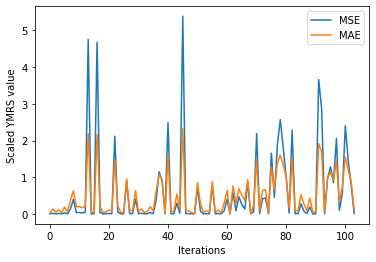

In [17]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(train_loss, label="MSE")
plt.plot(train_mae, label="MAE")
plt.legend()
plt.show()

### Model evaluation - validaton set

Subset taken from test data is defined as a validation set.

In [18]:
x_val, y_val = x_test[:30], y_test[:30]

In [19]:
eval_loss = []
eval_mae = []
index = 0

for input in x_val:
    input = reshape_X(input)
    scores = model.evaluate(input, y_val[index], verbose = 0)
    
    eval_loss.append(scores[0])
    eval_mae.append(scores[1])
    
    index += 1

In [20]:
avg_eval_loss = sum(eval_loss) / len(eval_loss)
avg_eval_mae = sum(eval_mae) / len(eval_mae)
print("Validation loss (avg):", avg_eval_loss, "Validation MAE (avg):", avg_eval_mae)

Validation loss (avg): 0.9448834865412209 Validation MAE (avg): 0.8090985645850499


In [21]:
real_eval_loss = round(float(scaler.inverse_transform(np.array(avg_eval_loss).reshape(-1,1))), 3)
real_eval_mae = round(float(scaler.inverse_transform(np.array(avg_eval_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_eval_loss}')
print(f'AVG MAE: {real_eval_mae}')

AVG MSE: 25.305
AVG MAE: 23.793


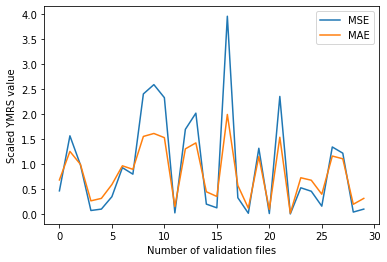

In [22]:
plt.xlabel("Number of validation files")
plt.ylabel("Scaled YMRS value")
plt.plot(eval_loss, label="MSE")
plt.plot(eval_mae, label="MAE")
plt.legend()
plt.show()

## Prediction

Prediction is made on different subset taken from the test dataset. Then actual and predicted YMRS values are compared.

In [23]:
x_pred, y_pred_actual = x_test[30:], y_test[30:]

In [24]:
y_prediction = []

pred_scores = []
pred_loss = []
pred_mae = []

pred_index = 0

for file in x_pred:
    file = np.array(file).reshape(1, file.shape[0], -1)
    pred_y = y_prediction.append(model.predict(file))
    
    scores = model.evaluate(file, y_pred_actual[pred_index], verbose=0)
    pred_scores.append(scores)
    pred_loss.append(scores[0])
    pred_mae.append(scores[1])
    
    pred_index += 1

### Model evaluation - prediction set

In [25]:
avg_pred_loss = sum(pred_loss) / len(pred_loss)
avg_pred_mae = sum(pred_mae) / len(pred_mae)
print("Prediction loss (avg):", avg_pred_loss, "Prediction MAE (avg):", avg_pred_mae)

Prediction loss (avg): 1.0924288761181136 Prediction MAE (avg): 0.9540646397819121


In [26]:
real_pred_loss = round(float(scaler.inverse_transform(np.array(avg_pred_loss).reshape(-1,1))), 3)
real_pred_mae = round(float(scaler.inverse_transform(np.array(avg_pred_mae).reshape(-1,1))), 3)

print(f'AVG MSE: {real_pred_loss}')
print(f'AVG MAE: {real_pred_mae}')

AVG MSE: 26.948
AVG MAE: 25.407


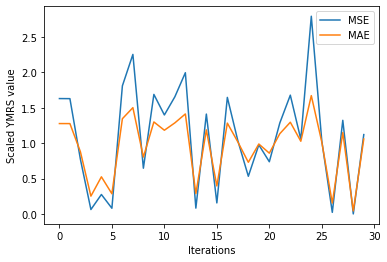

In [27]:
plt.xlabel("Iterations")
plt.ylabel("Scaled YMRS value")
plt.plot(pred_loss, label="MSE")
plt.plot(pred_mae, label="MAE")
plt.legend()
plt.show()

### Actual vs predicted comparison

In [28]:
y_prediction = np.array(y_prediction).reshape(-1, 1)
y_pred_actual = y_pred_actual.reshape(-1,1)

y_prediction = unscale_Y(y_prediction, scaler)
y_pred_actual = unscale_Y(y_pred_actual, scaler)

In [29]:
pred_df = pd.DataFrame(data=np.column_stack((y_pred_actual,y_prediction)),columns=['y_actual','y_pred'])
pred_df['pred_error'] = pred_df['y_actual'] - pred_df['y_pred']
pred_df = pred_df.sort_values(by=['y_actual']).reset_index()
pred_df['y_actual'] = pred_df['y_actual'].apply(np.int64)
pred_df

,index,y_actual,y_pred,pred_error
0,0,0,14.211779,-14.211779
1,1,0,14.206849,-14.206849
2,27,0,12.803745,-12.803745
3,22,0,14.420447,-14.420447
4,16,0,14.283504,-14.283504
5,6,0,14.974583,-14.974583
6,10,1,14.164191,-13.164191
7,29,2,13.789092,-11.789092
8,11,3,17.321960,-14.321960
9,17,3,14.328372,-11.328372


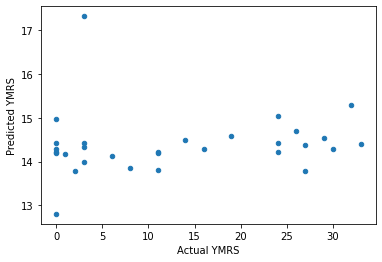

In [30]:
pred_df.plot('y_actual', 'y_pred', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Predicted YMRS")
plt.show()

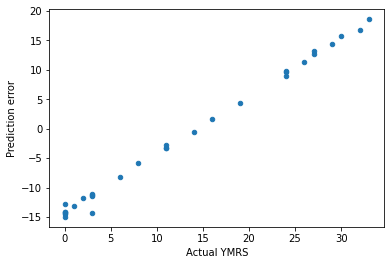

In [31]:
pred_df.plot('y_actual', 'pred_error', kind='scatter')
plt.xlabel("Actual YMRS")
plt.ylabel("Prediction error")
plt.show()

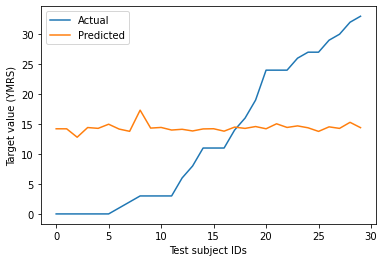

In [32]:
plt.xlabel("Test subject IDs")
plt.ylabel("Target value (YMRS)")
plt.plot(pred_df['y_actual'], label="Actual")
plt.plot(pred_df['y_pred'], label="Predicted")
plt.legend()
plt.show()